In [1]:
import pandas as pd
import numpy as np
import os, gc, math, sys, re
import os,sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm import *
from geopy.distance import vincenty
from datetime import datetime as dt
from datetime import datetime, timedelta
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
from sklearn.cluster import KMeans
import time
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
import tabulate as t
import holidays as h

In [2]:
from matplotlib import rc
rc('font',**{'family':'Droid Sans'})

In [44]:
def jobs_manager():
    from IPython.lib.backgroundjobs import BackgroundJobManager
    from IPython.core.magic import register_line_magic
    from IPython import get_ipython

    jobs = BackgroundJobManager()

    @register_line_magic
    def job(line):
        ip = get_ipython()
        jobs.new(line, ip.user_global_ns)

    return jobs

In [45]:
def kill_thread(thread):
    import ctypes
    
    id = thread.ident
    code = ctypes.pythonapi.PyThreadState_SetAsyncExc(
        ctypes.c_long(id),
        ctypes.py_object(SystemError)
    )
    if code == 0:
        raise ValueError('invalid thread id')
    elif code != 1:
        ctypes.pythonapi.PyThreadState_SetAsyncExc(
            ctypes.c_long(id),
            ctypes.c_long(0)
        )
        raise SystemError('PyThreadState_SetAsyncExc failed')

In [46]:
jobs = jobs_manager()

Data fields

- PID - patient ID (unique for each patient)
- EID - exam ID (unique for each patient visit)
- Modality - scanner name (MR1 or MR2)
- Exam - exam name (abbreviated). Corresponds to a particular type of scaning (exam)
- Scheduled - time when the exam was scheduled
- Arrive - time when the patient arrived for this exam
- Begin, Complete - time when exam started/ended
- Scan start - time when scanner started scanning (should be after Begin, but before Complete)
- In PACS - time when the exam was sent to the hospital PACS (Picture Archiving and Communication System) - digital archive of medical images.

Datetime format: MM/DD/YY HH:MM

Scheduled, Arrive, Begin and Complete timestamps are entered manually and may contain errors.



In [50]:
df = pd.read_excel('MRIDataOneYear.xlsx')

- очень странно, почему все секунды обрезаны? это дата в Excel или особенности HIS?

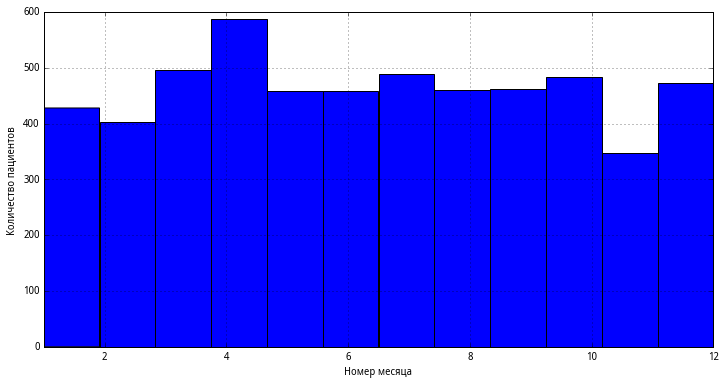

In [59]:
plt.figure(figsize=[12,6])
a = plt.hist(list(map(lambda x: x.month, df.Scheduled)),bins = 12,range = [1,12])
plt.xlim([1,12])
plt.grid(True)
plt.xlabel('Номер месяца')
plt.ylabel('Количество пациентов')

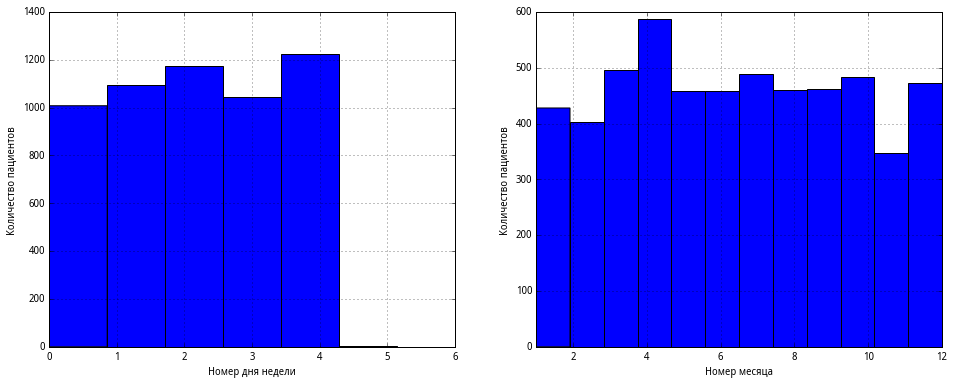

In [77]:
plt.figure(figsize=[16,6])
plt.subplot(121)
a = plt.hist(list(map(lambda x: x.weekday(), df.Scheduled)),bins = 7,range = [0,6],)
plt.xlabel('Номер дня недели')
plt.ylabel('Количество пациентов')
plt.xlim([0,6])
plt.grid(True)
plt.subplot(122)
a = plt.hist(list(map(lambda x: x.month, df.Scheduled)),bins = 12,range = [1,12])
plt.xlim([1,12])
plt.grid(True)
plt.xlabel('Номер месяца')
plt.ylabel('Количество пациентов')

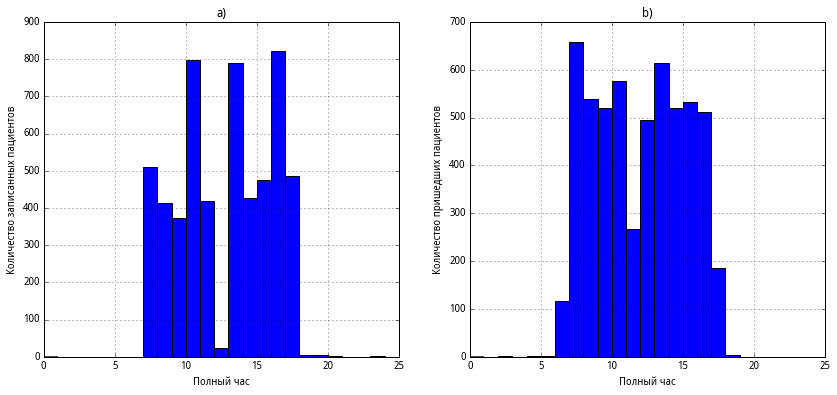

In [79]:
plt.figure(figsize=[14,6])
plt.subplot(121)
a = plt.hist(list(map(lambda x: x.hour, df.Scheduled)),bins = 24,range = [0,24],)
plt.title('a)')
plt.xlabel('Полный час')
plt.ylabel('Количество записанных пациентов')
plt.grid(True)
plt.subplot(122)
a = plt.hist(list(map(lambda x: x.hour, df.Arrive)),bins = 24,range = [0,24],)
plt.title('b)')
plt.xlabel('Полный час')
plt.ylabel('Количество пришедших пациентов')
plt.grid(True)

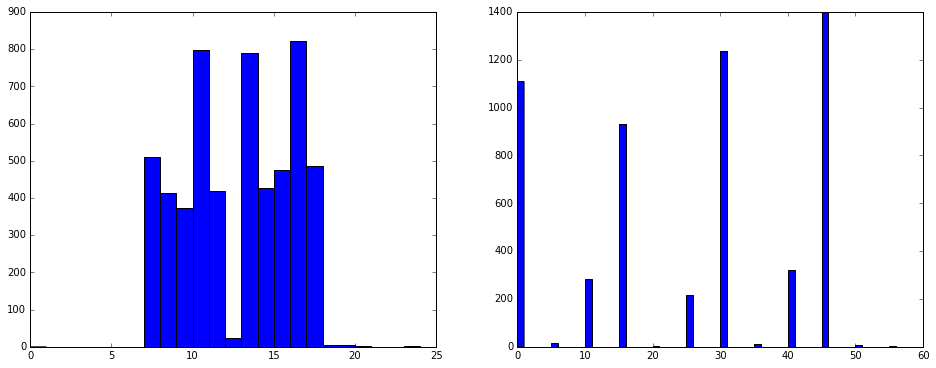

In [3]:
plt.figure(figsize=[16,6])
plt.subplot(121)
a = plt.hist(list(map(lambda x: x.hour, df.Scheduled)),bins = 24,range = [0,24],)
plt.subplot(122)
a = plt.hist(list(map(lambda x: x.minute, df.Scheduled)),bins = 60,range = [0,60])

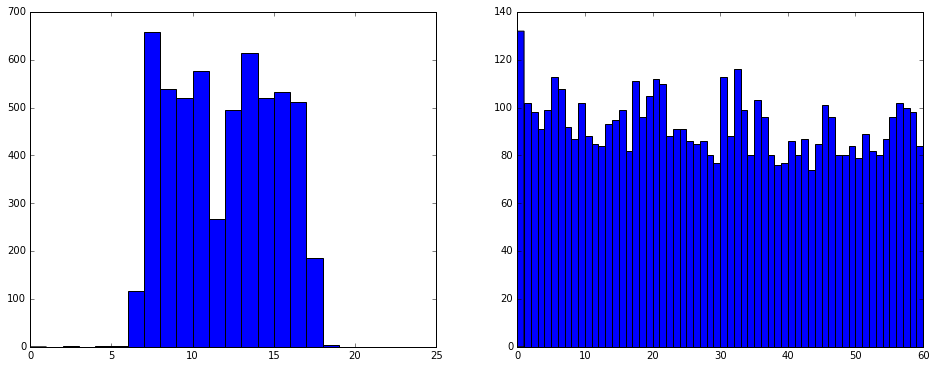

In [4]:
plt.figure(figsize=[16,6])
plt.subplot(121)
a = plt.hist(list(map(lambda x: x.hour, df.Arrive)),bins = 24,range = [0,24],)
plt.subplot(122)
a = plt.hist(list(map(lambda x: x.minute, df.Arrive)),bins = 60,range = [0,60])

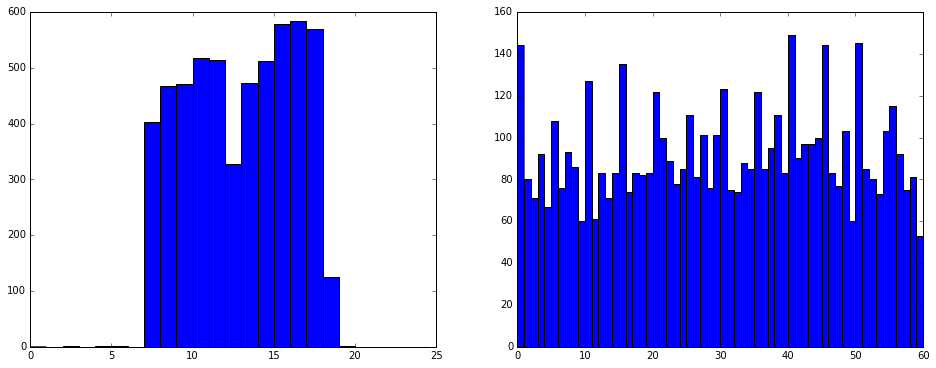

In [5]:
plt.figure(figsize=[16,6])
plt.subplot(121)
a = plt.hist(list(map(lambda x: x.hour, df.Begin)),bins = 24,range = [0,24],)
plt.subplot(122)
a = plt.hist(list(map(lambda x: x.minute, df.Begin)),bins = 60,range = [0,60])

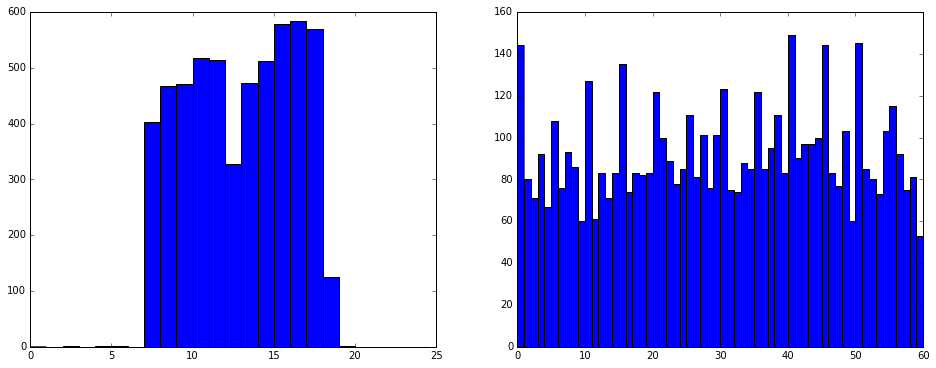

In [6]:
plt.figure(figsize=[16,6])
plt.subplot(121)
a = plt.hist(list(map(lambda x: x.hour, df['Scan start'])),bins = 24,range = [0,24],)
plt.subplot(122)
a = plt.hist(list(map(lambda x: x.minute, df['Scan start'])),bins = 60,range = [0,60])

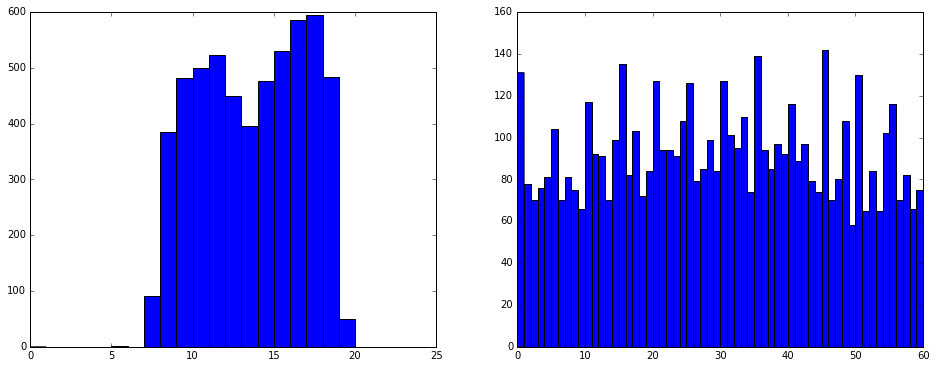

In [7]:
plt.figure(figsize=[16,6])
plt.subplot(121)
a = plt.hist(list(map(lambda x: x.hour, df.Complete)),bins = 24,range = [0,24],)
plt.subplot(122)
a = plt.hist(list(map(lambda x: x.minute, df.Complete)),bins = 60,range = [0,60])

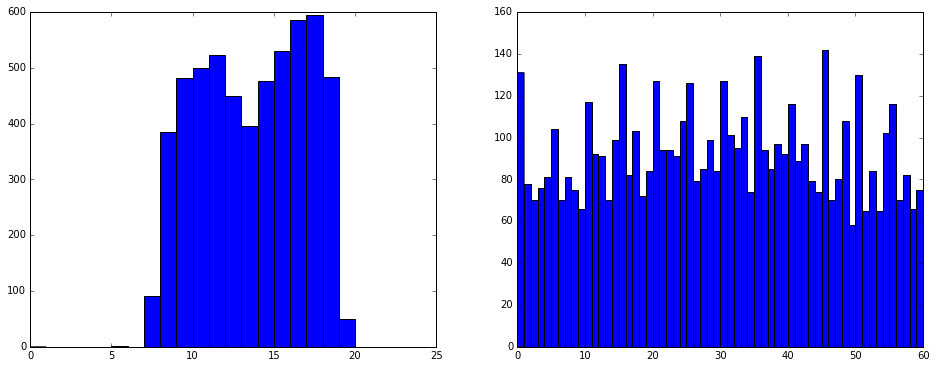

In [8]:
plt.figure(figsize=[16,6])
plt.subplot(121)
a = plt.hist(list(map(lambda x: x.hour, df['In PACS'])),bins = 24,range = [0,24],)
plt.subplot(122)
a = plt.hist(list(map(lambda x: x.minute, df['In PACS'])),bins = 60,range = [0,60])

In [9]:
sum(df['Begin'] > df['Scan start'])

0

In [10]:
sum(df['Scan start'] > df['Complete'])

0

# В этом блоке я буду реализовывать функции для вытягивания фичей

In [51]:
unix_date = datetime(2010, 1, 1,0,0,0)
td = timedelta(seconds=1)
for i in ['Scheduled', 'Arrive', 'Begin','Scan start', 'Complete', 'In PACS']:
    df[i+'_UNIX'] = list(map(lambda x: (x - unix_date) /  td, df[i]))

In [52]:
hour = datetime.strptime('17.10.10 10:10:10','%d.%m.%y %H:%M:%S') - datetime.strptime('10.10.10 09:10:10','%d.%m.%y %H:%M:%S')
day = datetime.strptime('02.10.10','%d.%m.%y') - datetime.strptime('01.10.10','%d.%m.%y')
week = datetime.strptime('17.10.10 10:10:10','%d.%m.%y %H:%M:%S') - datetime.strptime('10.10.10 10:10:10','%d.%m.%y %H:%M:%S')
month = datetime.strptime('01.10.10','%d.%m.%y') - datetime.strptime('01.09.10','%d.%m.%y')

In [53]:
# время ожидания от прихода

# TARGET

def time_of_expected(df):
    df['time_of_expected'] = df.Begin - df.Arrive
    df['time_of_expected'] = list(map(lambda x: x.delta/1000000000,tqdm(df['time_of_expected'])))
    return df

# добавить дамии на месяц (но сейчас у нас эта штука не будет иметь значение (по идее) так как мы используем как тест один обособленный месяц)
df['month'] = list(map(lambda x: x.month, df.Arrive))

# добавить дамми на день недели
df['day_of_week'] = list(map(lambda x: datetime.weekday(x), df.Arrive))

# изменить года для нового датасета
us_hol = h.US(state='MA', years=[2013,2014,2015])
# добавить расстояние до ближайщего справа праздника
def right(x, hol = us_hol):
    days = []
    for i in us_hol:
        days.append((datetime.date(x)-i).days)
    day = np.min(pd.Series(days)[pd.Series(days) >= 0])
    return day
df['right_holiday'] = list(map(lambda x: right(x), tqdm(df.Arrive)))
# добавить расстояние до ближайщего слева праздника
def left(x):
    days = []
    for i in us_hol:
        days.append((datetime.date(x)-i).days)
    day = np.max(pd.Series(days)[pd.Series(days) <= 0])
    return day
df['left_holiday'] = list(map(lambda x: left(x), tqdm(df.Arrive)))
                          
df['is_holiday'] = list(map(lambda x: int(x in us_hol), df.Arrive))

def mape(y_true, y_pred):
    x = list(filter(lambda x: x[0] != 0, zip(y_true, y_pred)))
    y_true = [i[0] for i in x]
    y_pred = [i[1] for i in x]
    #y_true, y_pred = check_array(y_true, y_pred)
    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((pd.Series(y_true) - pd.Series(y_pred)) / pd.Series(y_true).astype(float))) * 100
def quality(true,pred):
    res_df = pd.DataFrame()
    res_df['true'] = true
    res_df['pred'] = pred
    res_df['t-p'] = res_df['true'] - res_df['pred']
    res_df['t-p'] = list(map(lambda x: abs(x), res_df['t-p']))
    res_df = res_df[res_df['true'] != 0]
    return np.mean(res_df['t-p'])/np.mean(res_df['true'])
def quality2(true,pred):
    res_df = pd.DataFrame()
    res_df['true'] = true
    res_df['pred'] = pred
    res_df['t-p'] = res_df['true'] - res_df['pred']
    res_df['t-p'] = list(map(lambda x: x*x, res_df['t-p']))
    res_df = res_df[res_df['true'] != 0]
    return np.mean(res_df['t-p'])/np.mean(res_df['true']*res_df['true'])

# время ожидание от запланированного приема (может быть отрицательным)

def time_of_expected_on_shedule(df):
    df['time_of_expected_on_shedule'] = df.Begin - df.Scheduled
    df['time_of_expected_on_shedule'] = list(map(lambda x: x.delta/1000000000,df['time_of_expected_on_shedule']))
    return df

# сколько выполнялось исследование (может быть оооочень большим)

def time_of_procedure(df):
    df['time_of_procedure'] = df['Complete'] - df['Begin']
    df['time_of_procedure'] = list(map(lambda x: x.delta/1000000000,df['time_of_procedure']))
    return df

# !!!
# сколько пациентов находилось в очереди за delta секунд

def lq(x,y,delta = 0, df = df):
    return df[(df.Arrive_UNIX < x-delta) & (df.Begin_UNIX > x-delta) & (df.Modality == y)].shape[0]
def len_of_queque(df, delta = 0):
    df['len_of_queque_before_'+str(delta)+'_seconds'] = list(map(lambda x, y: lq(x,y,delta,df) , df.Arrive_UNIX, df.Modality))
    return df

# !!!
# количество зашедших на исследование за некоторое время

# time_delta в секундах

def come_in(x,df,time_delta):
    return df[(df.Begin_UNIX >= ((x - unix_date)/td - time_delta) ) & (df.Begin_UNIX <= (x - unix_date)/td )].shape[0]
def count_who_come_in(df,time_delta):
    df['count_who_come_in_previous_'+str(time_delta)+'_seconds'] = list(map(lambda x, y: come_in(x,df[df.Modality == y],time_delta) 
                                                                            , df.Arrive, df.Modality))
    return df

# !!!
# количество вышедших с исследования за некоторое время

# time_delta в секундах

def come_out(x,df,time_delta):
    return df[(df.Complete_UNIX >= ((x - unix_date)/td - time_delta) ) & (df.Complete_UNIX <= (x - unix_date)/td )].shape[0]
def count_who_come_out(df,time_delta):
    df['count_who_come_out_previous_'+str(time_delta)+'_seconds'] = list(map(lambda x, y: come_out(x,df[df.Modality == y],time_delta) , df.Arrive, df.Modality))
    return df

# !!!
# количество пришедших в госпиталь за некоторое время

# time_delta в секундах

def arrive_in(x,df,time_delta):
    return df[(df.Arrive_UNIX >= ((x - unix_date)/td - time_delta) ) & (df.Arrive_UNIX <= (x - unix_date)/td )].shape[0]

def count_who_arrive_in(df,time_delta):
    df['count_who_arrive_in_previous_'+str(time_delta)+'_seconds'] = list(map(lambda x, y: 
            arrive_in(x,df[df.Modality == y],time_delta) , df.Arrive, df.Modality))
    return df

# !!!
# среднее время ожидания по всем людям, которые пришли за некоторый промежуток времени (и уже зашли на исследование)

def mean_time(x,df, period):
    return np.mean(df[(df.Begin < x) & (df.Arrive >= x - period)].time_of_expected)
def mean_time_of_exp(df,multiply = 1,period = day):
    # period as time in unix
    if period == day:
        name = 'day'
    elif period == hour:
        name = 'hour'
    elif period == week:
        name = 'week'
    else:
        name = 'month'
    df['mean_time_of_exp_'+str(multiply)+'_'+name] = list(map(
            lambda x,y: mean_time(x,df[df.Modality == y], period*multiply), df.Arrive, df.Modality))
    return df

# !!!
# оклонение по всем людям, которые пришли за некоторый промежуток времени

def std_time(x,df, period):
    return np.std(df[(df.Begin < x)  & (df.Arrive >= x - period)].time_of_expected)
def std_time_of_exp(df,multiply = 1,period = day):
    # period as time in unix
    if period == day:
        name = 'day'
    elif period == hour:
        name = 'hour'
    elif period == week:
        name = 'week'
    else:
        name = 'month'
    df['std_time_of_exp_'+str(multiply)+'_'+name] = list(map(lambda x,y: std_time(x,df[df.Modality == y], period*multiply), df.Arrive, df.Modality))
    return df

# !!!
# среднее время проведения исследования по всем людям, которые пришли за некоторый промежуток времени

def mean_time_2(x,df, period):
    return np.mean(df[(df.Complete < x) & (df.Arrive >= x - period)].time_of_procedure)
def mean_time_of_proced(df,multiply = 1,period = day):
    # period as time in unix
    if period == day:
        name = 'day'
    elif period == hour:
        name = 'hour'
    elif period == week:
        name = 'week'
    else:
        name = 'month'
    df['mean_time_of_proced_'+str(multiply)+'_'+name] = list(map(lambda x,y: mean_time_2(x,df[df.Modality == y], period*multiply), df.Arrive, df.Modality))
    return df

# !!!
# оклонение проведения исследования по всем людям, которые пришли за некоторый промежуток времени

def std_time_2(x,df, period):
    return np.std(df[(df.Complete < x) & (df.Arrive >= x - period)].time_of_procedure)
def std_time_of_proced(df,multiply = 1,period = day):
    # period as time in unix
    if period == day:
        name = 'day'
    elif period == hour:
        name = 'hour'
    elif period == week:
        name = 'week'
    else:
        name = 'month'
    df['std_time_of_proced_'+str(multiply)+'_'+name] = list(map(lambda x,y: std_time_2(x,df[df.Modality == y], period*multiply), df.Arrive, df.Modality))
    return df

# !!!
# среднее время отклонения от расписания по всем людям, которые пришли за некоторый промежуток времени

def mean_time_3(x,df, period):
    return np.mean(df[(df.Begin < x) & (df.Arrive >= x - period)].time_of_expected_on_shedule)
def mean_time_of_exp_schel(df,multiply = 1,period = day):
    # period as time in unix
    if period == day:
        name = 'day'
    elif period == hour:
        name = 'hour'
    elif period == week:
        name = 'week'
    else:
        name = 'month'
    df['mean_time_of_exp_schel_'+str(multiply)+'_'+name] = list(map(lambda x,y: mean_time_3(x,df[df.Modality == y], period*multiply), df.Arrive, df.Modality))
    return df

# !!!
# оклонение отклонения от расписания по всем людям, которые пришли за некоторый промежуток времени

def std_time_3(x,df, period):
    return np.std(df[(df.Begin < x) & (df.Arrive >= x - period)].time_of_expected_on_shedule)
def std_time_of_exp_schel(df,multiply = 1,period = day):
    # period as time in unix
    if period == day:
        name = 'day'
    elif period == hour:
        name = 'hour'
    elif period == week:
        name = 'week'
    else:
        name = 'month'
    df['std_time_of_exp_schel_'+str(multiply)+'_'+name] = list(map(lambda x,y: std_time_3(x,df[df.Modality == y], period*multiply), df.Arrive, df.Modality))
    return df

# пациент с какой модальностью сейчас на исследовании

def closest_modality(df):
    df_ = df.copy()
    df_.sort_values('Begin_UNIX',ascending = False)
    return df_.loc[0,'Exam']
def now_with_doctor(df):
    df['now_with_doctor'] = list(map(lambda x,y: closest_modality(df[(df.Modality == y) & (df.Begin_UNIX < x)]), df.Begin_UNIX, df.Modality ))
    return df

# посмотреть распределение модальностей для тех ребят, которые сейчас внутри

# среднее время по всем проведенным ранее исследованием в данной области
def mean_by_exam(df):
    df['mean_by_exam'] = list(map(lambda x,y: np.mean(df[(df.Begin < x) & (df.Exam == y)].time_of_procedure), df.Arrive, df.Exam))
    return df

def sign_no_queue(df):
    df['no_queue'] = list(map(
            lambda x,y: int(df[(df.Begin>x) &(df.Arrive<x)&(df.Modality == y)].shape[0] == 0),df.Arrive, df.Modality ))
    return df

# разница во времени между пришедшим сейчас и пришедшим перед

# предсказанное время ожидания для того, кто пришел перед текущим человеком

# зашел ли тот человек, который пришел перед тобой, в кабинете

# вышел ли тот человек, который пришел перед тобой, из кабинета

df = time_of_expected(df)

df = time_of_expected_on_shedule(df)

df = time_of_procedure(df)

for i in tqdm(range(0,181,15)):
    df = len_of_queque(df,i*60)

for i in tqdm(range(0,181,15)):
    df = count_who_come_in(df,60*i)

for i in tqdm(range(0,181,15)):
    df = count_who_arrive_in(df,60*i)

for i in tqdm(range(1,8)):
    for j in [hour,day]:
        df = mean_time_of_exp(df,i,j)
        df = std_time_of_exp(df,i,j)
        df = mean_time_of_proced(df,i,j)
        df = std_time_of_proced(df,i,j)
        df = mean_time_of_exp_schel(df,i,j)
        df = std_time_of_exp_schel(df,i,j)

for i in tqdm(range(8,13,2)):    
    df = mean_time_of_exp(df,i,day)
    df = std_time_of_exp(df,i,day)
    df = mean_time_of_proced(df,i,day)
    df = std_time_of_proced(df,i,day)
    df = mean_time_of_exp_schel(df,i,day)
    df = std_time_of_exp_schel(df,i,day)

df = mean_by_exam(df)
df = sign_no_queue(df)

In [136]:
for i in list(df.columns[22:]):
    #df[i] = df[i].fillna(0)
    if sum(pd.isnull(df[i])) > 0:
        df[i] = df[i].fillna(np.mean(df[i]))
        print(sum(pd.isnull(df[i])),'\t',np.mean(df[i]),'\t',i)

0 	 3392.6654166856297 	 mean_time_of_exp_1_hour
0 	 2060.182436322381 	 std_time_of_exp_1_hour
0 	 2721.1653111353107 	 mean_time_of_proced_1_hour
0 	 1046.032044000324 	 std_time_of_proced_1_hour
0 	 275.55005861763186 	 mean_time_of_exp_schel_1_hour
0 	 6310.971467947049 	 std_time_of_exp_schel_1_hour
0 	 3234.6459374887486 	 mean_time_of_exp_1_day
0 	 1625.4417976364537 	 std_time_of_exp_1_day
0 	 2705.350577104181 	 mean_time_of_proced_1_day
0 	 757.7300773531241 	 std_time_of_proced_1_day
0 	 161.6696311305274 	 mean_time_of_exp_schel_1_day
0 	 3786.494105772583 	 std_time_of_exp_schel_1_day
0 	 3404.5544297654073 	 mean_time_of_exp_2_hour
0 	 2111.842442174206 	 std_time_of_exp_2_hour
0 	 2725.25230996965 	 mean_time_of_proced_2_hour
0 	 1131.8297482924959 	 std_time_of_proced_2_hour
0 	 293.5513139245387 	 mean_time_of_exp_schel_2_hour
0 	 7712.638960556841 	 std_time_of_exp_schel_2_hour
0 	 3302.664915457849 	 mean_time_of_exp_2_day
0 	 1792.7322634347502 	 std_time_of_exp_2_d

In [137]:
def dummie_train(df, col):
    uniq = df[col].unique()
    for i in uniq:
        name = col + '_'+ str(i)
        df.loc[:,name] = df[col] == i
        df.loc[:,name] = df.loc[:,name].astype(int)
    return df, uniq
def dummie_test(df, col, uniq):
    for i in uniq:
        name = col + '_'+ str(i)
        df.loc[:,name] = df[col] == i
        df.loc[:,name] = df.loc[:,name].astype(int)
    return df

In [138]:
for i in tqdm(['Modality','day_of_week','month']):
    df,temp_uniq = dummie_train(df,i)

100%|██████████| 3/3 [00:00<00:00, 24.64it/s]


# Сохраним обновленный датафрэйм в пикл

In [139]:
df.to_pickle('new_dataFrame_with_features_19_06_20-26.pkl')

# !!!!!!!!!!!!!!!!

# Загрузим из пикла

In [2]:
df = pd.read_pickle('new_dataFrame.pkl')

# Выберем фичи для модели

In [157]:
pd.Series(df.columns[18:21]+df.columns[24:144])

/home/dac/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: using '+' to provide set union with Indexes is deprecated, use '|' or .union()
  if __name__ == '__main__':


0          count_who_arrive_in_previous_0_seconds
1      count_who_arrive_in_previous_10800_seconds
2       count_who_arrive_in_previous_1800_seconds
3       count_who_arrive_in_previous_2700_seconds
4       count_who_arrive_in_previous_3600_seconds
5       count_who_arrive_in_previous_4500_seconds
6       count_who_arrive_in_previous_5400_seconds
7       count_who_arrive_in_previous_6300_seconds
8       count_who_arrive_in_previous_7200_seconds
9       count_who_arrive_in_previous_8100_seconds
10      count_who_arrive_in_previous_9000_seconds
11       count_who_arrive_in_previous_900_seconds
12      count_who_arrive_in_previous_9900_seconds
13           count_who_come_in_previous_0_seconds
14       count_who_come_in_previous_10800_seconds
15        count_who_come_in_previous_1800_seconds
16        count_who_come_in_previous_2700_seconds
17        count_who_come_in_previous_3600_seconds
18        count_who_come_in_previous_4500_seconds
19        count_who_come_in_previous_5400_seconds


In [158]:
cols = list(df.columns[18:21]+df.columns[24:144])
cols

/home/dac/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: using '+' to provide set union with Indexes is deprecated, use '|' or .union()
  if __name__ == '__main__':


['count_who_arrive_in_previous_0_seconds',
 'count_who_arrive_in_previous_10800_seconds',
 'count_who_arrive_in_previous_1800_seconds',
 'count_who_arrive_in_previous_2700_seconds',
 'count_who_arrive_in_previous_3600_seconds',
 'count_who_arrive_in_previous_4500_seconds',
 'count_who_arrive_in_previous_5400_seconds',
 'count_who_arrive_in_previous_6300_seconds',
 'count_who_arrive_in_previous_7200_seconds',
 'count_who_arrive_in_previous_8100_seconds',
 'count_who_arrive_in_previous_9000_seconds',
 'count_who_arrive_in_previous_900_seconds',
 'count_who_arrive_in_previous_9900_seconds',
 'count_who_come_in_previous_0_seconds',
 'count_who_come_in_previous_10800_seconds',
 'count_who_come_in_previous_1800_seconds',
 'count_who_come_in_previous_2700_seconds',
 'count_who_come_in_previous_3600_seconds',
 'count_who_come_in_previous_4500_seconds',
 'count_who_come_in_previous_5400_seconds',
 'count_who_come_in_previous_6300_seconds',
 'count_who_come_in_previous_7200_seconds',
 'count_who

In [159]:
target = 'time_of_expected'

# Выделим тест и трэйн

In [160]:
print(min(df.Arrive))
print(max(df.Arrive))

2014-04-07 06:48:00
2015-04-10 17:49:00


In [161]:
df_temp = df.sort_values('time_of_expected')
df_temp = df_temp[4:df.shape[0]-3]
date_threshold_1 = datetime.strptime('01.03.2015','%d.%m.%Y')
train = df_temp[df_temp.Arrive < date_threshold_1]
test = df_temp[df_temp.Arrive >= date_threshold_1]
Train = train.sort_values('Arrive')
Test = test.sort_values('Arrive')

In [162]:
print(df.shape)
print(df_temp.shape)

(5546, 187)
(5539, 187)


In [163]:
Train.shape

(4856, 187)

In [164]:
Test.shape

(683, 187)

In [165]:
Test.shape[0]/(Test.shape[0]+Train.shape[0])

0.1233074562195342

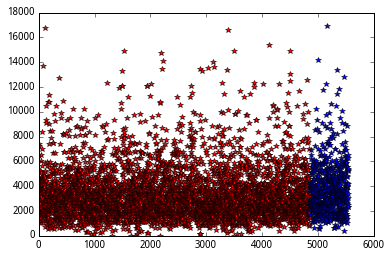

In [166]:
plt.plot(Train.time_of_expected,'*r')
plt.plot(Test.time_of_expected,'*b')

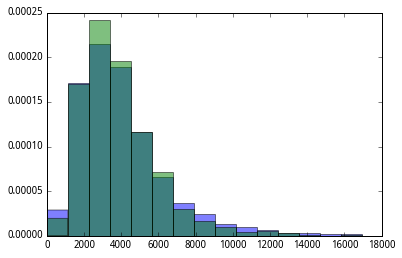

In [167]:
temp_hist = plt.hist(list(Train.time_of_expected*1.2),15,
                     [min([min(Train.time_of_expected),min(Test.time_of_expected)]),max([max(Train.time_of_expected),max(Test.time_of_expected)])],
                    True,alpha = 0.5, )
temp_hist = plt.hist(Test.time_of_expected, 15, 
                     [min([min(Train.time_of_expected),min(Test.time_of_expected)]),max([max(Train.time_of_expected),max(Test.time_of_expected)])],
                    True,alpha = 0.5)

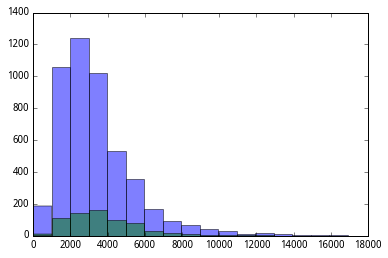

In [168]:
temp_hist = plt.hist(list(Train.time_of_expected),17,
                     [min([min(Train.time_of_expected),min(Test.time_of_expected)]),max([max(Train.time_of_expected),max(Test.time_of_expected)])],
                    alpha = 0.5, )
temp_hist = plt.hist(Test.time_of_expected, 17, 
                     [min([min(Train.time_of_expected),min(Test.time_of_expected)]),max([max(Train.time_of_expected),max(Test.time_of_expected)])],
                    alpha = 0.5)

## C валидационной выборкой

In [169]:
df_temp = df.sort_values('time_of_expected')
df_temp = df_temp[4:df.shape[0]-3]
date_threshold_1 = datetime.strptime('01.02.2015','%d.%m.%Y')
date_threshold_2 = datetime.strptime('01.03.2015','%d.%m.%Y')
train = df_temp[df_temp.Arrive < date_threshold_1]
val = df_temp[(df_temp.Arrive >= date_threshold_1) & (df_temp.Arrive < date_threshold_2) ]
test = df_temp[df_temp.Arrive >= date_threshold_2]
train = train.sort_values('Arrive')
val = val.sort_values('Arrive')
test = test.sort_values('Arrive')

In [170]:
print(train.shape[0])
print(val.shape[0])
print(test.shape[0])

4453
403
683


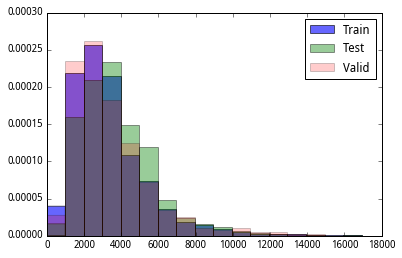

In [181]:
temp_hist = plt.hist(list(train.time_of_expected),17,
                     [min([min(train.time_of_expected),min(test.time_of_expected)]),max([max(train.time_of_expected),max(test.time_of_expected)])],
                    True,alpha = 0.6, )
temp_hist = plt.hist(test.time_of_expected, 17, 
                     [min([min(train.time_of_expected),min(test.time_of_expected)]),max([max(train.time_of_expected),max(test.time_of_expected)])],
                    True,alpha = 0.4)
temp_hist = plt.hist(val.time_of_expected, 17, 
                     [min([min(train.time_of_expected),min(test.time_of_expected)]),max([max(train.time_of_expected),max(test.time_of_expected)])],
                    True,alpha = 0.2)
plt.legend(['Train','Test','Valid'])

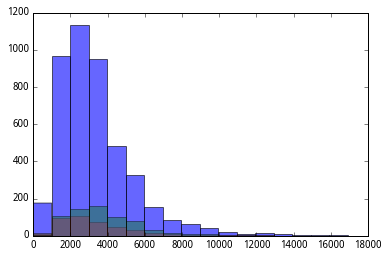

In [172]:
temp_hist = plt.hist(list(train.time_of_expected),17,
                     [min([min(train.time_of_expected),min(test.time_of_expected)]),max([max(train.time_of_expected),max(test.time_of_expected)])],
                    alpha = 0.6, )
temp_hist = plt.hist(test.time_of_expected, 17, 
                     [min([min(train.time_of_expected),min(test.time_of_expected)]),max([max(train.time_of_expected),max(test.time_of_expected)])],
                    alpha = 0.4)
temp_hist = plt.hist(val.time_of_expected, 17, 
                     [min([min(train.time_of_expected),min(test.time_of_expected)]),max([max(train.time_of_expected),max(test.time_of_expected)])],
                    alpha = 0.2)

# Модели

In [183]:
import sklearn.tree as tree
import sklearn.cross_validation as cv

In [184]:
import sklearn.linear_model as lin

In [185]:
import sklearn.ensemble as ens

In [186]:
model = ens.GradientBoostingRegressor()

In [187]:
model = lin.ARDRegression()

In [18]:
temp = df.describe()

In [19]:
temp.transpose()

count          mean           std  \
PID                               5546.0  4.865914e+06  1.271559e+06   
EID                               5546.0  2.523297e+07  4.113273e+05   
Scheduled_UNIX                    5546.0  1.503558e+08  9.382725e+06   
Arrive_UNIX                       5546.0  1.503526e+08  9.383465e+06   
Begin_UNIX                        5546.0  1.503561e+08  9.383572e+06   
Scan start_UNIX                   5546.0  1.503561e+08  9.383572e+06   
Complete_UNIX                     5546.0  1.503588e+08  9.383585e+06   
In PACS_UNIX                      5546.0  1.503588e+08  9.383585e+06   
day_of_week                       5546.0  2.070141e+00  1.412281e+00   
right_holiday                     5546.0  1.750415e+01  1.227831e+01   
left_holiday                      5546.0 -1.836098e+01  1.224834e+01   
is_holiday                        5546.0  1.153985e-02  1.068117e-01   
time_of_expected                  5546.0  3.433058e+03  2.258236e+03   
time_of_expected_on_shedule       5546.0  2.567580e+02  4.092532e+04   
time_of_procedure                 5546.0  2.736091e+03  1.713793e+03   
len_of_queque_before_0_seconds    5546.0  5.445366e-01  6.817867e-01   
len_of_queque_before_10_seconds   5546.0  5.613054e-01  6.878642e-01   
len_of_queque_before_20_seconds   5546.0  5.613054e-01  6.878642e-01   
len_of_queque_before_30_seconds   5546.0  5.613054e-01  6.878642e-01   
len_of_queque_before_40_seconds   5546.0  5.613054e-01  6.878642e-01   
len_of_queque_before_50_seconds   5546.0  5.613054e-01  6.878642e-01   
len_of_queque_before_60_seconds   5546.0  5.531915e-01  6.845992e-01   
len_of_queque_before_70_seconds   5546.0  5.686982e-01  6.918730e-01   
len_of_queque_before_80_seconds   5546.0  5.686982e-01  6.918730e-01   
len_of_queque_before_90_seconds   5546.0  5.686982e-01  6.918730e-01   
len_of_queque_before_100_seconds  5546.0  5.686982e-01  6.918730e-01   
len_of_queque_before_110_seconds  5546.0  5.686982e-01  6.918730e-01   
len_of_queque_before_120_seconds  5546.0  5.609448e-01  6.884203e-01   
len_of_queque_before_130_seconds  5546.0  5.726650e-01  6.945902e-01   
len_of_queque_before_140_seconds  5546.0  5.726650e-01  6.945902e-01   
...                                  ...           ...           ...   
Exam_MRAMESWWO                    5546.0  3.606203e-04  1.898829e-02   
Exam_MRAASCWWO                    5546.0  1.803101e-04  1.342796e-02   
Exam_MRIARMWO                     5546.0  5.409304e-04  2.325372e-02   
Exam_MRIABWWWO                    5546.0  5.409304e-04  2.325372e-02   
Exam_MRIELBWWO                    5546.0  1.803101e-04  1.342796e-02   
Exam_MRIANKWWO                    5546.0  1.803101e-04  1.342796e-02   
Exam_MRAUPEWWO                    5546.0  1.803101e-04  1.342796e-02   
Exam_MRICHCWO                     5546.0  3.606203e-04  1.898829e-02   
Exam_MRIPITWO                     5546.0  3.606203e-04  1.898829e-02   
Exam_MRICHCWWO                    5546.0  7.212405e-04  2.684866e-02   
Exam_MRANCKW                      5546.0  3.966823e-03  6.286334e-02   
Exam_MRIENTWO                     5546.0  1.803101e-04  1.342796e-02   
Exam_MRIKNEW                      5546.0  1.803101e-04  1.342796e-02   
Exam_MRAHEDW                      5546.0  1.803101e-04  1.342796e-02   
Exam_MRIKNEWWO                    5546.0  1.803101e-04  1.342796e-02   
Exam_MRIENTW                      5546.0  1.081861e-03  3.287682e-02   
Exam_MRISINWO                     5546.0  1.803101e-04  1.342796e-02   
Exam_MRICPWO                      5546.0  1.803101e-04  1.342796e-02   
Exam_MRICARWWO                    5546.0  7.933646e-03  8.872498e-02   
Exam_MRAAORWO                     5546.0  1.803101e-04  1.342796e-02   
Exam_MRICARWO                     5546.0  3.606203e-04  1.898829e-02   
Exam_MRIMEDWO                     5546.0  1.803101e-04  1.342796e-02   
Exam_MRILIVW                      5546.0  1.803101e-04  1.342796e-02   
Exam_MRITMJWWO                    5546.0  1.803101e-04  1.342796e-02   
day

# Линейная регрессия

In [198]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

quality-L1  0.3458850980984894
quality-L2  0.203792125852973
mae  1329.23187421
R^2  0.118196031424
mape  41.11381396927129
mse 3914352.743136
mean diff in minute  6.034819813035517
***


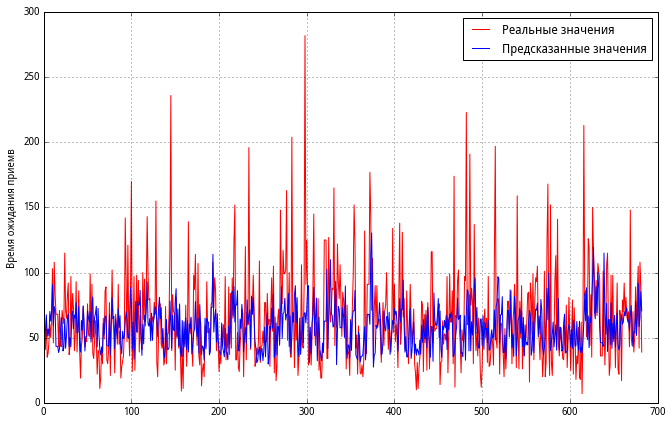

In [239]:
model = lin.LinearRegression(fit_intercept=True)
model.fit(Train[cols],Train[target].values)
res = model.predict(Test[cols])
print('quality-L1 ',quality(Test[target].values, res))
print('quality-L2 ',quality2(Test[target].values, res))
print('mae ',mean_absolute_error(Test[target].values, res))
print('R^2 ',model.score(Test[cols],test[target].values))
print('mape ',mape(list(Test[target].values), list(res)))
print('mse %f'% mean_squared_error(list(Test[target].values), list(res)))
print('mean diff in minute ',np.mean((pd.Series(Test[target].values) - pd.Series(res))/60))
print('***')
plt.figure(figsize=[11,7])
plt.plot(pd.Series(test[target].values)/60,'r')
plt.plot(res/60,'b')
plt.grid(True)
plt.ylabel('Время ожидания приемв')
plt.legend(['Реальные значения','Предсказанные значения'])

quality-L1  0.34553974104482044
quality-L2  0.20222174488747446
mae  1327.9046716
R^2  0.124991034723
mape  41.73523719805323
mse 3884189.531410
mean diff in minute  5.436169481864406
***


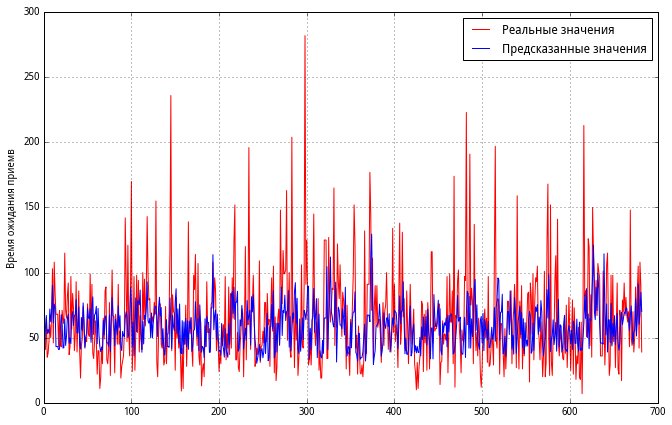

In [230]:
model = lin.LinearRegression(fit_intercept=False)
model.fit(Train[cols],Train[target].values)
res = model.predict(Test[cols])
print('quality-L1 ',quality(Test[target].values, res))
print('quality-L2 ',quality2(Test[target].values, res))
print('mae ',mean_absolute_error(Test[target].values, res))
print('R^2 ',model.score(Test[cols],test[target].values))
print('mape ',mape(list(Test[target].values), list(res)))
print('mse %f'% mean_squared_error(list(Test[target].values), list(res)))
print('mean diff in minute ',np.mean((pd.Series(Test[target].values) - pd.Series(res))/60))
print('***')
plt.figure(figsize=[11,7])
plt.plot(pd.Series(test[target].values)/60,'r')
plt.plot(res/60,'b')
plt.grid(True)
plt.ylabel('Время ожидания приемв')
plt.legend(['Реальные значения','Предсказанные значения'])

/home/dac/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


quality-L1  0.3430465149111871
quality-L2  0.19986100594068168
mae  1318.32323643
R^2  0.135205899323
mape  41.31155970516728
mse 3838845.458701
mean diff in minute  5.332808903203887
***


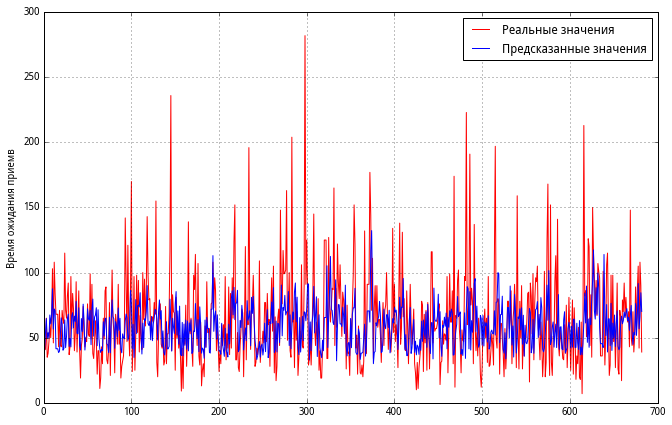

In [214]:
model = lin.Lasso(fit_intercept=True)
model.fit(Train[cols],Train[target].values)
res = model.predict(Test[cols])
print('quality-L1 ',quality(Test[target].values, res))
print('quality-L2 ',quality2(Test[target].values, res))
print('mae ',mean_absolute_error(Test[target].values, res))
print('R^2 ',model.score(Test[cols],test[target].values))
print('mape ',mape(list(Test[target].values), list(res)))
print('mse %f'% mean_squared_error(list(Test[target].values), list(res)))
print('mean diff in minute ',np.mean((pd.Series(Test[target].values) - pd.Series(res))/60))
print('***')
plt.figure(figsize=[11,7])
plt.plot(pd.Series(test[target].values)/60,'r')
plt.plot(res/60,'b')
plt.grid(True)
plt.ylabel('Время ожидания приемв')
plt.legend(['Реальные значения','Предсказанные значения'])

quality-L1  0.34027337744693814
quality-L2  0.1958845394026362
mae  1307.66610569
R^2  0.152411981056
mape  41.64222843893006
mse 3762467.175507
mean diff in minute  5.041788009260875
***


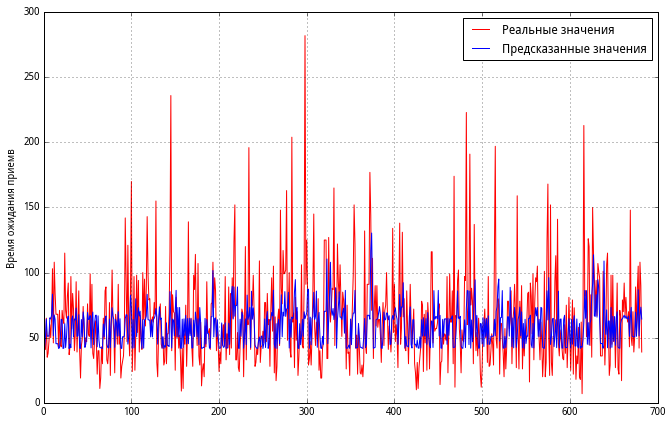

In [284]:
model = lin.LassoLars(fit_intercept=True)
model.fit(Train[cols],Train[target].values)
res = model.predict(Test[cols])
print('quality-L1 ',quality(Test[target].values, res))
print('quality-L2 ',quality2(Test[target].values, res))
print('mae ',mean_absolute_error(Test[target].values, res))
print('R^2 ',model.score(Test[cols],test[target].values))
print('mape ',mape(list(Test[target].values), list(res)))
print('mse %f'% mean_squared_error(list(Test[target].values), list(res)))
print('mean diff in minute ',np.mean((pd.Series(Test[target].values) - pd.Series(res))/60))
print('***')
plt.figure(figsize=[11,7])
plt.plot(pd.Series(test[target].values)/60,'r')
plt.plot(res/60,'b')
plt.grid(True)
plt.ylabel('Время ожидания приемв')
plt.legend(['Реальные значения','Предсказанные значения'])

In [266]:
def results(true, pred):
    return {'quality-L1':quality(true, pred),
            'quality-L2':quality2(true, pred),
            'mae':mean_absolute_error(true, pred),
            'R^2':metrics.r2_score(true, pred),
            'mape':mape(true, pred),
            'mse': mean_squared_error(true, pred),
            'mean diff in minute':np.mean((pd.Series(true) - pd.Series(pred))/60)
           }

In [278]:
d = {}
for i in tqdm(range(2,150)):
    alpha = i/100
    model = lin.LassoLars(alpha=alpha)
    model.fit(Train[cols],Train[target].values)
    res = model.predict(Test[cols])
    d.update([(alpha,results(test[target].values, res))])

100%|██████████| 148/148 [00:03<00:00, 37.80it/s]


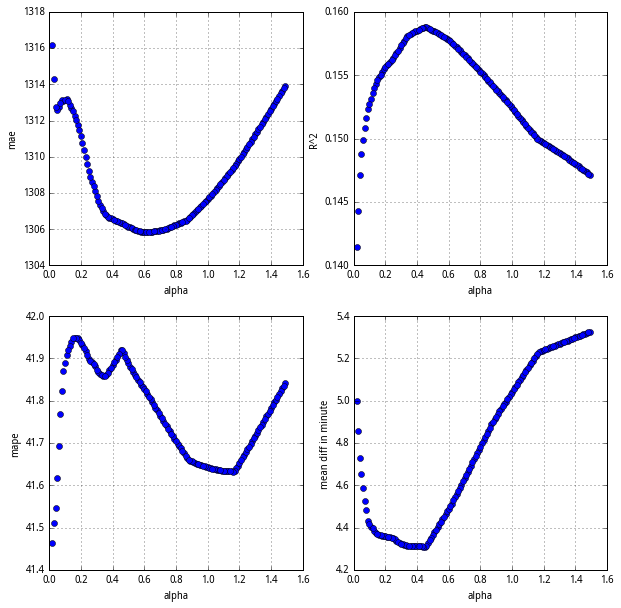

In [279]:
plt.figure(figsize=[10,10])
k = 1
for i in ['mae', 'R^2', 'mape', 'mean diff in minute']:
    plt.subplot(220+k)
    k = k + 1
    plt.plot([j for j in d],[d[j][i] for j in d],'o')
    plt.ylabel(i)
    plt.xlabel('alpha')
    plt.grid(True)

In [277]:
d

{0.01: {'R^2': 0.10250589153611833,
  'mae': 1342.1671766920542,
  'mape': 41.47352996020918,
  'mean diff in minute': 4.029556931734236,
  'mse': 3984001.7176209725,
  'quality-L1': 0.3492510483551537,
  'quality-L2': 0.20741824580313906},
 0.02: {'R^2': 0.1414265236726886,
  'mae': 1316.186732284782,
  'mape': 41.462273075601466,
  'mean diff in minute': 4.998621209272561,
  'mse': 3811231.9313675733,
  'quality-L1': 0.34249056605194583,
  'quality-L2': 0.19842336865889346},
 0.03: {'R^2': 0.1443000026335225,
  'mae': 1314.2905081900019,
  'mape': 41.51033721589623,
  'mean diff in minute': 4.854379815755488,
  'mse': 3798476.4770336123,
  'quality-L1': 0.34199714148865845,
  'quality-L2': 0.19775928411528765},
 0.04: {'R^2': 0.14714416450248435,
  'mae': 1312.7642057975947,
  'mape': 41.54736722207661,
  'mean diff in minute': 4.731040130021222,
  'mse': 3785851.1620992003,
  'quality-L1': 0.34159997583007845,
  'quality-L2': 0.19710197499194404},
 0.05: {'R^2': 0.14876757101620897,

## Попробуем добавлять фичи по очереди
## Посмотрим, как уменьшается ошибка

61.302119167213064   std_time_of_proced_7_hour
61.29777932529913   std_time_of_proced_6_hour
61.42723646530238   std_time_of_proced_6_day
61.42921530902945   std_time_of_proced_5_hour
61.42921530902945   std_time_of_proced_5_day
61.42921530902945   std_time_of_proced_4_hour
61.42921530902945   std_time_of_proced_4_day
61.42921530902945   std_time_of_proced_3_hour
61.42921530902945   std_time_of_proced_3_day
61.42921530902945   std_time_of_proced_2_hour
61.42921530902945   std_time_of_proced_2_day
61.42921530902945   std_time_of_proced_1_hour
61.42921530902945   std_time_of_proced_1_day
61.06251254342941   std_time_of_exp_schel_7_hour
61.06803504608759   std_time_of_exp_schel_6_hour
61.06803504608759   std_time_of_exp_schel_6_day
61.07549608250219   std_time_of_exp_schel_5_hour
61.07549608250219   std_time_of_exp_schel_5_day
61.07549608250219   std_time_of_exp_schel_4_hour
61.07549608250219   std_time_of_exp_schel_4_day
61.07549608250219   std_time_of_exp_schel_3_hour
61.07549608250219 

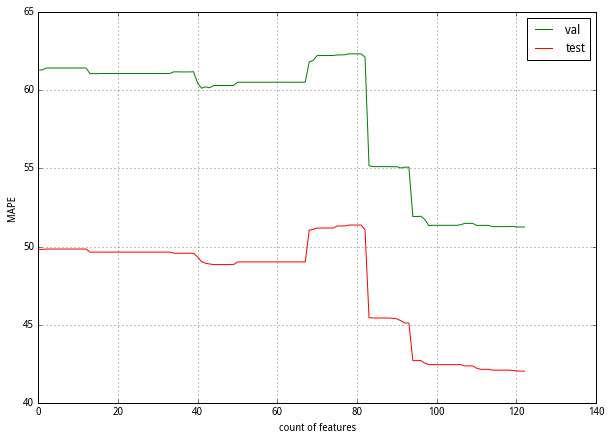

In [286]:
our_features = cols.copy()
using_features = []
j = 0
Q = []
Q_test = []
while len(our_features) != 0:
    L1 = {}
    L1_test = {}
    for j in (our_features):
        model = lin.LassoLars(fit_intercept=True, alpha = 0.45)
        model.fit(train[using_features+[j]],train[target].values)
        res = model.predict(val[using_features+[j]])
        L1.update([(j,mape(list(val[target].values), list(res)))])
        res_test = model.predict(test[using_features+[j]])
        L1_test.update([(j,mape(list(test[target].values), list(res_test)))])
    L1_s = []
    #print(L1)
    for key in sorted(L1,reverse = True):
        #print(L1)
        L1_s.append([key, L1[key]])
    using_features.append(L1_s[0][0])
    print(L1_s[0][1],' ',L1_s[0][0])
    Q.append(L1_s[0][1])
    Q_test.append(L1_test[L1_s[0][0]])
    #print(L1_s[0][0])
    our_features.remove(L1_s[0][0])
plt.figure(figsize=[10,7])
ax = plt.subplot(111)
ax.plot(Q,'g',label = 'val')
ax.plot(Q_test,'r',label = 'test')
plt.ylabel('MAPE')
plt.xlabel('count of features')
plt.grid(True)
ax.legend()

0.4526781972107685   std_time_of_proced_7_hour
0.4526697476558456   std_time_of_proced_6_hour
0.45317844588647677   std_time_of_proced_6_day
0.4531811951544154   std_time_of_proced_5_hour
0.4531811951544154   std_time_of_proced_5_day
0.4531811951544154   std_time_of_proced_4_hour
0.4531811951544154   std_time_of_proced_4_day
0.4531811951544154   std_time_of_proced_3_hour
0.4531811951544154   std_time_of_proced_3_day
0.4531811951544154   std_time_of_proced_2_hour
0.4531811951544154   std_time_of_proced_2_day
0.4531811951544154   std_time_of_proced_1_hour
0.4531811951544154   std_time_of_proced_1_day
0.4522178597776232   std_time_of_exp_schel_7_hour
0.4522311637286711   std_time_of_exp_schel_6_hour
0.4522311637286711   std_time_of_exp_schel_6_day
0.45225056278783066   std_time_of_exp_schel_5_hour
0.45225056278783066   std_time_of_exp_schel_5_day
0.45225056278783066   std_time_of_exp_schel_4_hour
0.45225056278783066   std_time_of_exp_schel_4_day
0.45225056278783066   std_time_of_exp_schel

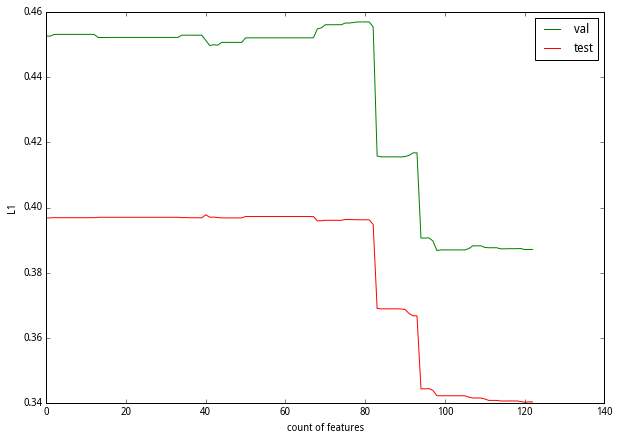

In [281]:
our_features = cols.copy()
using_features = []
j = 0
Q = []
Q_test = []
while len(our_features) != 0:
    L1 = {}
    L1_test = {}
    for j in (our_features):
        model = lin.LassoLars(fit_intercept=True, alpha = 0.45)
        model.fit(train[using_features+[j]],train[target].values)
        res = model.predict(val[using_features+[j]])
        L1.update([(j,quality(val[target].values, res))])
        res = model.predict(test[using_features+[j]])
        L1_test.update([(j,quality(test[target].values, res))])

    L1_s = []
    #print(L1)
    for key in sorted(L1,reverse = True):
        #print(L1)
        L1_s.append([key, L1[key]])
    using_features.append(L1_s[0][0])
    Q.append(L1_s[0][1])
    Q_test.append(L1_test[L1_s[0][0]])
    print(L1_s[0][1],' ',L1_s[0][0])
    #print(L1_s[0][0])
    our_features.remove(L1_s[0][0])
plt.figure(figsize=[10,7])
ax = plt.subplot(111)
ax.plot(Q,'g',label = 'val')
ax.plot(Q_test,'r',label = 'test')
plt.ylabel('L1')
plt.grid(True)
plt.xlabel('count of features')
ax.legend()

In [255]:
import sklearn.metrics as metrics

1563.93916536   std_time_of_proced_7_hour
1563.89452864   std_time_of_proced_6_hour
1567.73074075   std_time_of_proced_6_day
1567.75073552   std_time_of_proced_5_hour
1567.13930845   std_time_of_proced_5_day
1567.12201072   std_time_of_proced_4_hour
1566.80874642   std_time_of_proced_4_day
1566.93625496   std_time_of_proced_3_hour
1567.13313203   std_time_of_proced_3_day
1567.15291711   std_time_of_proced_2_hour
1569.39772863   std_time_of_proced_2_day
1570.03613779   std_time_of_proced_1_hour
1569.26179344   std_time_of_proced_1_day
1564.01749032   std_time_of_exp_schel_7_hour
1564.05835251   std_time_of_exp_schel_6_hour
1563.73995132   std_time_of_exp_schel_6_day
1563.81924505   std_time_of_exp_schel_5_hour
1563.98642994   std_time_of_exp_schel_5_day
1564.00455189   std_time_of_exp_schel_4_hour
1564.21207515   std_time_of_exp_schel_4_day
1564.06101922   std_time_of_exp_schel_3_hour
1564.10260521   std_time_of_exp_schel_3_day
1563.88582523   std_time_of_exp_schel_2_hour
1563.70945037 

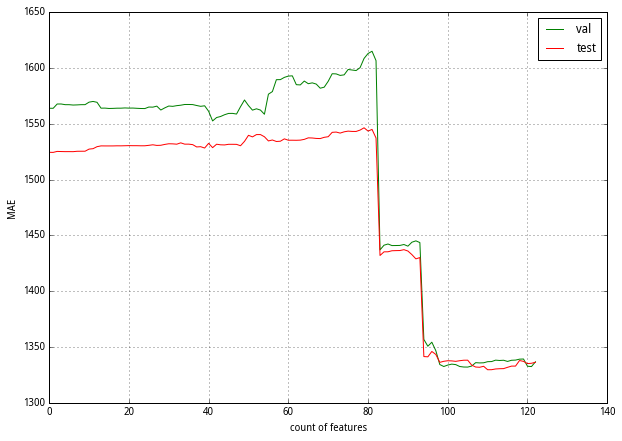

In [287]:
our_features = cols.copy()
using_features = []
j = 0
Q = []
Q_test = []
while len(our_features) != 0:
    L1 = {}
    L1_test = {}
    for j in (our_features):
        model = lin.LinearRegression(fit_intercept=True)
        model.fit(train[using_features+[j]],train[target].values)
        res = model.predict(val[using_features+[j]])
        L1.update([(j,metrics.regression.mean_absolute_error(val[target].values, res))])
        res_test = model.predict(test[using_features+[j]])
        L1_test.update([(j,metrics.regression.mean_absolute_error(test[target].values, res_test))])

    L1_s = []
    #print(L1)
    for key in sorted(L1,reverse = True):
        #print(L1)
        L1_s.append([key, L1[key]])
    using_features.append(L1_s[0][0])
    Q.append(L1_s[0][1])
    Q_test.append(L1_test[L1_s[0][0]])
    print(L1_s[0][1],' ',L1_s[0][0])
    #print(L1_s[0][0])
    our_features.remove(L1_s[0][0])
plt.figure(figsize=[10,7])
ax = plt.subplot(111)
ax.plot(Q,'g',label = 'val')
ax.plot(Q_test,'r',label = 'test')
plt.grid(True)
plt.ylabel('MAE')
plt.xlabel('count of features')
ax.legend()


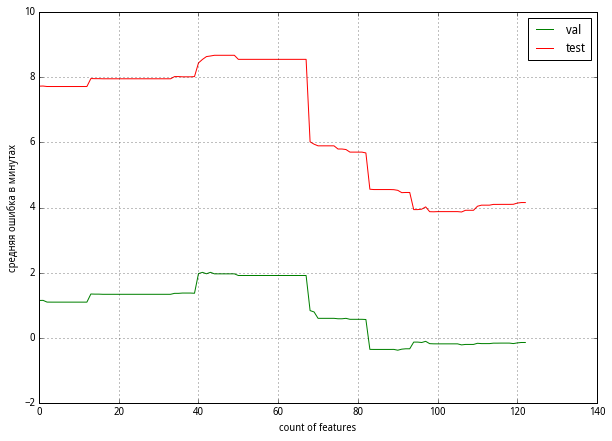

In [290]:
our_features = cols.copy()
using_features = []
j = 0
Q = []
Q_test = []
while len(our_features) != 0:
    L1 = {}
    L1_test = {}
    for j in (our_features):
        model = lin.LassoLars(fit_intercept=True, alpha = 0.45)
        model.fit(train[using_features+[j]],train[target].values)
        res = model.predict(val[using_features+[j]])
        #L1.update([(j,np.mean((pd.Series(np.abs(val[target].values) - pd.Series(res)))/60))])
        L1.update([(j,np.mean((pd.Series(val[target].values) - pd.Series(res))/60))])
        res_test = model.predict(test[using_features+[j]])
        #L1_test.update([(j,np.mean(np.abs(pd.Series(test[target].values) - pd.Series(res_test))/60))])
        L1_test.update([(j,np.mean((pd.Series(test[target].values) - pd.Series(res_test)))/60)])

    L1_s = []
    #print(L1)
    for key in sorted(L1,reverse = True):
        #print(L1)
        L1_s.append([key, L1[key]])
    using_features.append(L1_s[0][0])
    Q.append(L1_s[0][1])
    Q_test.append(L1_test[L1_s[0][0]])
    #print(L1_s[0][1],' ',L1_s[0][0])
    #print(L1_s[0][0])
    our_features.remove(L1_s[0][0])
plt.figure(figsize=[10,7])
ax = plt.subplot(111)
ax.plot(Q,'g',label = 'val')
ax.plot(Q_test,'r',label = 'test')
plt.ylabel('средняя ошибка в минутах')
plt.xlabel('count of features')
plt.grid(True)
ax.legend()


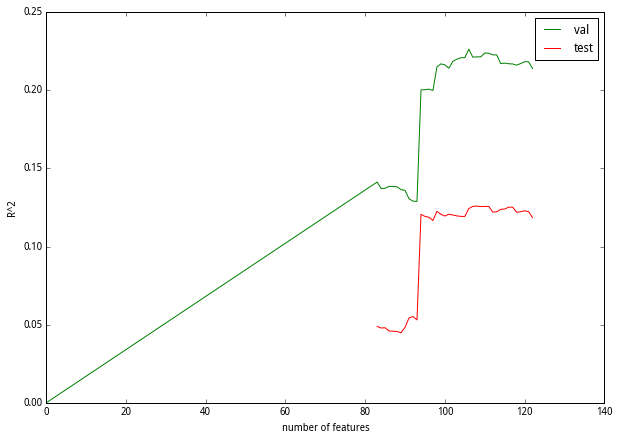

In [258]:
our_features = cols.copy()
using_features = []
j = 0
Q = []
Q_test = []
while len(our_features) != 0:
    L1 = {}
    L1_test = {}
    for j in (our_features):
        model = lin.LinearRegression(fit_intercept=True)
        model.fit(train[using_features+[j]],train[target].values)
        res = model.predict(val[using_features+[j]])
        L1.update([(j,metrics.r2_score(val[target].values,res))])
        res_test = model.predict(test[using_features+[j]])
        L1_test.update([(j,metrics.r2_score(test[target].values,res_test))])
    L1_s = []
    #print(L1)
    for key in sorted(L1,reverse = True):
        #print(L1)
        L1_s.append([key, L1[key]])
    using_features.append(L1_s[0][0])
    Q.append(L1_s[0][1])
    Q_test.append(L1_test[L1_s[0][0]])
    #print(L1_s[0][0])
    our_features.remove(L1_s[0][0])
plt.figure(figsize=[10,7])
ax = plt.subplot(111)
ax.plot(pd.Series(Q)[pd.Series(Q) >0],'g',label = 'val')
ax.plot(pd.Series(Q_test)[pd.Series(Q_test) >0],'r',label = 'test')
plt.ylabel('R^2')
plt.xlabel('number of features')
ax.legend()

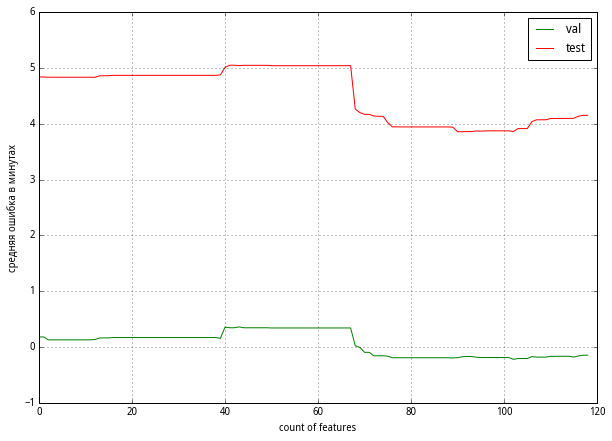

In [293]:
using_features = ['len_of_queque_before_900_seconds', 'len_of_queque_before_0_seconds', 
                  'count_who_come_in_previous_9900_seconds','count_who_come_in_previous_900_seconds']
our_features = list(set(cols.copy()).difference(set(using_features)))
j = 0
Q = []
Q_test = []
while len(our_features) != 0:
    L1 = {}
    L1_test = {}
    for j in (our_features):
        model = lin.LassoLars(fit_intercept=True, alpha = 0.45)
        model.fit(train[using_features+[j]],train[target].values)
        res = model.predict(val[using_features+[j]])
        #L1.update([(j,np.mean((pd.Series(np.abs(val[target].values) - pd.Series(res)))/60))])
        L1.update([(j,np.mean((pd.Series(val[target].values) - pd.Series(res))/60))])
        res_test = model.predict(test[using_features+[j]])
        #L1_test.update([(j,np.mean(np.abs(pd.Series(test[target].values) - pd.Series(res_test))/60))])
        L1_test.update([(j,np.mean((pd.Series(test[target].values) - pd.Series(res_test)))/60)])

    L1_s = []
    #print(L1)
    for key in sorted(L1,reverse = True):
        #print(L1)
        L1_s.append([key, L1[key]])
    using_features.append(L1_s[0][0])
    Q.append(L1_s[0][1])
    Q_test.append(L1_test[L1_s[0][0]])
    #print(L1_s[0][1],' ',L1_s[0][0])
    #print(L1_s[0][0])
    our_features.remove(L1_s[0][0])
plt.figure(figsize=[10,7])
ax = plt.subplot(111)
ax.plot(Q,'g',label = 'val')
ax.plot(Q_test,'r',label = 'test')
plt.ylabel('средняя ошибка в минутах')
plt.xlabel('count of features')
plt.grid(True)
ax.legend()


1320.24027231   std_time_of_proced_7_hour
1320.24027231   std_time_of_proced_6_hour
1322.03763319   std_time_of_proced_6_day
1322.0403546   std_time_of_proced_5_hour
1322.0403546   std_time_of_proced_5_day
1322.0403546   std_time_of_proced_4_hour
1322.0403546   std_time_of_proced_4_day
1322.0403546   std_time_of_proced_3_hour
1322.0403546   std_time_of_proced_3_day
1322.0403546   std_time_of_proced_2_hour
1322.0403546   std_time_of_proced_2_day
1322.0403546   std_time_of_proced_1_hour
1322.00339854   std_time_of_proced_1_day
1321.72200951   std_time_of_exp_schel_7_hour
1321.69913136   std_time_of_exp_schel_6_hour
1321.69913136   std_time_of_exp_schel_6_day
1321.63275704   std_time_of_exp_schel_5_hour
1321.63275704   std_time_of_exp_schel_5_day
1321.63275704   std_time_of_exp_schel_4_hour
1321.63275704   std_time_of_exp_schel_4_day
1321.63275704   std_time_of_exp_schel_3_hour
1321.63275704   std_time_of_exp_schel_3_day
1321.63275704   std_time_of_exp_schel_2_hour
1321.63275704   std_tim

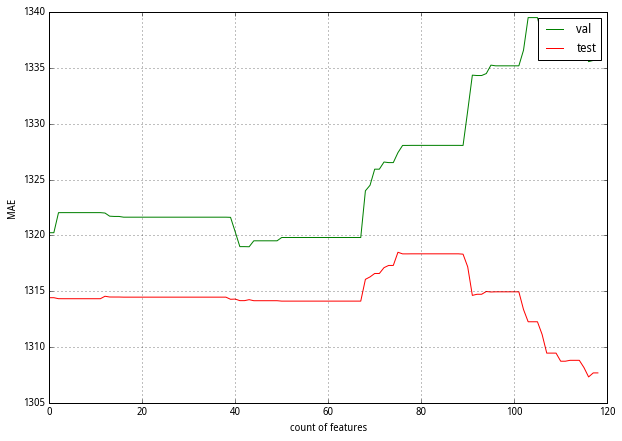

In [294]:
using_features = ['len_of_queque_before_900_seconds', 'len_of_queque_before_0_seconds', 
                  'count_who_come_in_previous_9900_seconds','count_who_come_in_previous_900_seconds']
our_features = list(set(cols.copy()).difference(set(using_features)))
j = 0
Q = []
Q_test = []
while len(our_features) != 0:
    L1 = {}
    L1_test = {}
    for j in (our_features):
        model = lin.LassoLars(fit_intercept=True, alpha = 0.45)
        model.fit(train[using_features+[j]],train[target].values)
        res = model.predict(val[using_features+[j]])
        L1.update([(j,metrics.regression.mean_absolute_error(val[target].values, res))])
        res_test = model.predict(test[using_features+[j]])
        L1_test.update([(j,metrics.regression.mean_absolute_error(test[target].values, res_test))])

    L1_s = []
    #print(L1)
    for key in sorted(L1,reverse = True):
        #print(L1)
        L1_s.append([key, L1[key]])
    using_features.append(L1_s[0][0])
    Q.append(L1_s[0][1])
    Q_test.append(L1_test[L1_s[0][0]])
    print(L1_s[0][1],' ',L1_s[0][0])
    #print(L1_s[0][0])
    our_features.remove(L1_s[0][0])
plt.figure(figsize=[10,7])
ax = plt.subplot(111)
ax.plot(Q,'g',label = 'val')
ax.plot(Q_test,'r',label = 'test')
plt.grid(True)
plt.ylabel('MAE')
plt.xlabel('count of features')
ax.legend()


# Байесовская регрессия

In [253]:
df_temp = df.sort_values('time_of_expected')
df_temp = df_temp[4:df.shape[0]-3]
date_threshold_1 = datetime.strptime('15.02.2015','%d.%m.%Y')
train = df_temp[df_temp.Arrive < date_threshold_1]
test = df_temp[df_temp.Arrive >= date_threshold_1]
train = train.sort_values('Arrive')
test = test.sort_values('Arrive')

In [254]:
from sklearn.linear_model import BayesianRidge, LinearRegression

quality-L1  0.34087532021911476
R^2  0.150046405755
mape  41.51110102108228
mean diff in minute  4.831043600877331


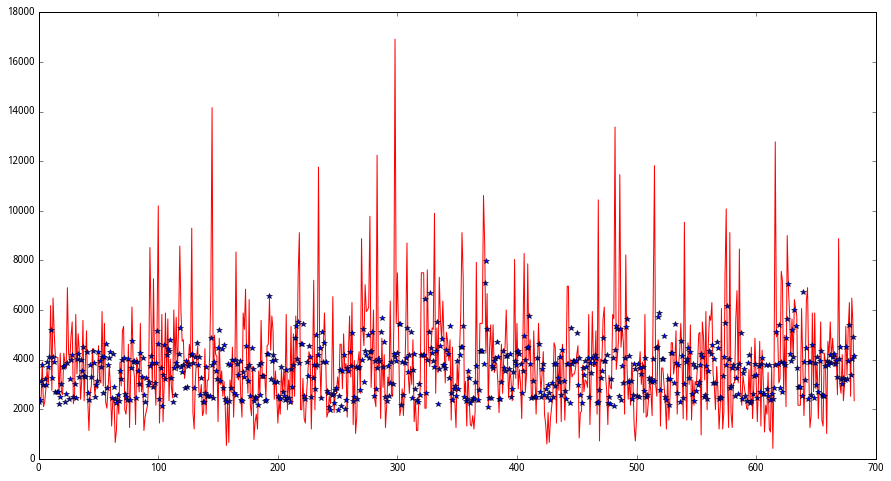

In [296]:
clf = lin.BayesianRidge(n_iter=100, tol=0.0001, alpha_1=1e-8, alpha_2=1e-10, lambda_1=1e-5, lambda_2=1e8,normalize=True)
clf.fit(Train[cols],Train[target].values)
res = clf.predict(Test[cols])
print('quality-L1 ',quality(Test[target].values, res))
#print(test[cols].shape)
#print(len(test[target].values))
print('R^2 ',clf.score(Test[cols],Test[target].values))
print('mape ',mape(list(Test[target].values), list(res)))
print('mean diff in minute ',np.mean((pd.Series(Test[target].values) - pd.Series(res))/60))
plt.figure(figsize=[15,8])
plt.plot(test[target].values,'-r')
plt.plot(res,'*b')

# Деревья (не показали должного результата)

In [297]:
from sklearn.tree import DecisionTreeRegressor,ExtraTreeRegressor

  0%|          | 0/5 [00:00<?, ?it/s]

{'mape': 43.37553206117272, 'R^2': 0.15218450893651669, 'mae': 1330.6664827173404, 'mean diff in minute': 4.608322639527884, 'mse': 3763476.9306772738, 'quality-L2': 0.19593711007428982, 'quality-L1': 0.3462584037001267}
{'mape': 41.99186111088207, 'R^2': 0.15857528628562734, 'mae': 1316.0584808556284, 'mean diff in minute': 4.508239334540806, 'mse': 3735108.0893715988, 'quality-L2': 0.1944601490395935, 'quality-L1': 0.34245719320029044}


 40%|████      | 2/5 [00:00<00:00, 12.70it/s]

{'mape': 41.66976932827718, 'R^2': 0.1634379355460156, 'mae': 1297.4001582501198, 'mean diff in minute': 4.128870121979021, 'mse': 3713522.6518485234, 'quality-L2': 0.19333635093325047, 'quality-L1': 0.3376020314561453}


 60%|██████    | 3/5 [00:00<00:00, 10.51it/s]

{'mape': 42.49368880839688, 'R^2': 0.1297499816545058, 'mae': 1314.3059530047267, 'mean diff in minute': 3.3819289966707657, 'mse': 3863064.4314559968, 'quality-L2': 0.2011219132394295, 'quality-L1': 0.34200116044980444}


 80%|████████  | 4/5 [00:00<00:00,  8.59it/s]

{'mape': 42.48206252809706, 'R^2': 0.13806491283678812, 'mae': 1317.0240232370811, 'mean diff in minute': 3.4873426470224174, 'mse': 3826154.2168933502, 'quality-L2': 0.19920026448035855, 'quality-L1': 0.3427084411035394}


100%|██████████| 5/5 [00:00<00:00,  7.04it/s]


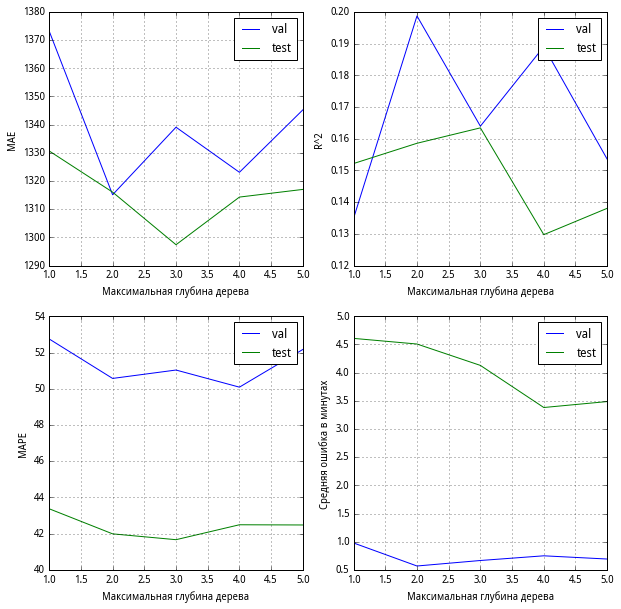

In [308]:
plt.figure(figsize=[10,10])
t_1 = []
t_2 = []
t_3 = []
t_4 = []
t_1_ = []
t_2_ = []
t_3_ = []
t_4_ = []
n = 6
for md in tqdm(range(1,n)):
    model = tree.DecisionTreeRegressor(max_depth=md,min_samples_leaf=1,random_state=42)
    model.fit(train[cols],train[target].values)
    res = model.predict(val[cols])
    res_test = model.predict(test[cols])
    t_1.append(mean_absolute_error(val[target].values, res))
    t_2.append(model.score(val[cols],val[target].values))
    t_3.append((mape(list(val[target].values), list(res))))
    t_4.append(np.mean((pd.Series(val[target].values) - pd.Series(res))/60))
    
    t_1_.append(mean_absolute_error(test[target].values, res_test))
    t_2_.append(model.score(test[cols],test[target].values))
    t_3_.append((mape(list(test[target].values), list(res_test))))
    t_4_.append(np.mean((pd.Series(test[target].values) - pd.Series(res_test))/60))
    print(results(test[target].values, res_test))
plt.subplot(221)
plt.grid(True)
plt.plot(range(1,n),t_1)
plt.plot(range(1,n),t_1_)
plt.legend(['val','test'])
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('MAE')
plt.subplot(222)
plt.grid(True)
plt.plot(range(1,n),t_2)
plt.plot(range(1,n),t_2_)
plt.legend(['val','test'])
plt.ylabel('R^2')
plt.xlabel('Максимальная глубина дерева')
plt.subplot(223)
plt.grid(True)
plt.plot(range(1,n),t_3)
plt.plot(range(1,n),t_3_)
plt.legend(['val','test'])
plt.ylabel('MAPE')
plt.xlabel('Максимальная глубина дерева')
plt.subplot(224)
plt.plot(range(1,n),t_4)
plt.plot(range(1,n),t_4_)
plt.legend(['val','test'])
plt.ylabel('Средняя ошибка в минутах')
plt.xlabel('Максимальная глубина дерева')
plt.grid(True)

  0%|          | 0/6 [00:00<?, ?it/s]

{'mape': 46.75699720624309, 'R^2': 0.028355291244228642, 'mae': 1466.3772608685606, 'mean diff in minute': 6.4174359776223415, 'mse': 4313158.328388188, 'quality-L2': 0.22455505739081316, 'quality-L1': 0.3815722843891353}
{'mape': 43.19577850422088, 'R^2': 0.081416313977014765, 'mae': 1393.3912760096307, 'mean diff in minute': 6.653474842876833, 'mse': 4077618.9485609913, 'quality-L2': 0.21229222006189535, 'quality-L1': 0.3625802898225275}
{'mape': 41.652399820974345, 'R^2': 0.1195892013371338, 'mae': 1347.3598743969605, 'mean diff in minute': 5.826764384353975, 'mse': 3908168.4225073298, 'quality-L2': 0.20347015286523285, 'quality-L1': 0.35060226238327424}
{'mape': 40.72369444493522, 'R^2': 0.14755652919555839, 'mae': 1305.1161661715398, 'mean diff in minute': 5.240061995790351, 'mse': 3784020.6635700171, 'quality-L2': 0.1970066741309558, 'quality-L1': 0.3396098468031977}


 67%|██████▋   | 4/6 [00:00<00:00, 36.65it/s]

{'mape': 40.93714829576044, 'R^2': 0.17366867275894393, 'mae': 1301.2305407918548, 'mean diff in minute': 4.903828502567238, 'mse': 3668108.1201602905, 'quality-L2': 0.19097194369540207, 'quality-L1': 0.3385987516423737}
{'mape': 41.131430345214035, 'R^2': 0.13376600196788313, 'mae': 1316.988031826007, 'mean diff in minute': 4.899514475988339, 'mse': 3845237.2037610086, 'quality-L2': 0.2001937780231032, 'quality-L1': 0.3426990756248811}


100%|██████████| 6/6 [00:00<00:00, 33.74it/s]


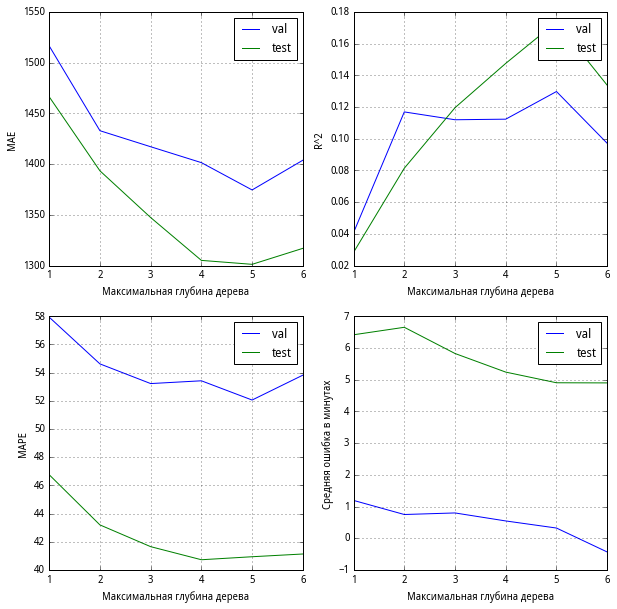

In [310]:
plt.figure(figsize=[10,10])
t_1 = []
t_2 = []
t_3 = []
t_4 = []
t_1_ = []
t_2_ = []
t_3_ = []
t_4_ = []
n = 7
for md in tqdm(range(1,n)):
    model = tree.ExtraTreeRegressor(max_depth=md,min_samples_leaf=2,random_state=42)
    model.fit(train[cols],train[target].values)
    res = model.predict(val[cols])
    res_test = model.predict(test[cols])
    t_1.append(mean_absolute_error(val[target].values, res))
    t_2.append(model.score(val[cols],val[target].values))
    t_3.append((mape(list(val[target].values), list(res))))
    t_4.append(np.mean((pd.Series(val[target].values) - pd.Series(res))/60))
    
    t_1_.append(mean_absolute_error(test[target].values, res_test))
    t_2_.append(model.score(test[cols],test[target].values))
    t_3_.append((mape(list(test[target].values), list(res_test))))
    t_4_.append(np.mean((pd.Series(test[target].values) - pd.Series(res_test))/60))
    print(results(test[target].values, res_test))
plt.subplot(221)
plt.grid(True)
plt.plot(range(1,n),t_1)
plt.plot(range(1,n),t_1_)
plt.legend(['val','test'])
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('MAE')
plt.subplot(222)
plt.grid(True)
plt.plot(range(1,n),t_2)
plt.plot(range(1,n),t_2_)
plt.legend(['val','test'])
plt.ylabel('R^2')
plt.xlabel('Максимальная глубина дерева')
plt.subplot(223)
plt.grid(True)
plt.plot(range(1,n),t_3)
plt.plot(range(1,n),t_3_)
plt.legend(['val','test'])
plt.ylabel('MAPE')
plt.xlabel('Максимальная глубина дерева')
plt.subplot(224)
plt.plot(range(1,n),t_4)
plt.plot(range(1,n),t_4_)
plt.legend(['val','test'])
plt.ylabel('Средняя ошибка в минутах')
plt.xlabel('Максимальная глубина дерева')
plt.grid(True)

1
quality-L1  0.3744760284325683
R^2  0.0618450025883
mape  45.74236260930785
mean diff in minute  6.705697549556507
***
2
quality-L1  0.3687981576436608
R^2  0.0907762791522
mape  45.357630055107315
mean diff in minute  6.260665274857148
***
3
quality-L1  0.3546986432977055
R^2  0.130238311535
mape  43.49930666429431
mean diff in minute  5.267793437900098
***
4
quality-L1  0.35703335723352597
R^2  0.134703911094
mape  44.03621947147643
mean diff in minute  5.025044485541821
***
5
quality-L1  0.35963204495538953
R^2  0.104249839134
mape  42.58199166019185
mean diff in minute  6.318714622853385
***
6
quality-L1  0.3459089354061836
R^2  0.138516042348
mape  40.98526521222634
mean diff in minute  5.3746215706052345
***
7
quality-L1  0.3493121879432631
R^2  0.130784787399
mape  40.65313891334755
mean diff in minute  7.086080004700984
***
8
quality-L1  0.36465966735319877
R^2  0.0753509533004
mape  42.76404906688813
mean diff in minute  4.927740072969758
***
9
quality-L1  0.3758602164058018

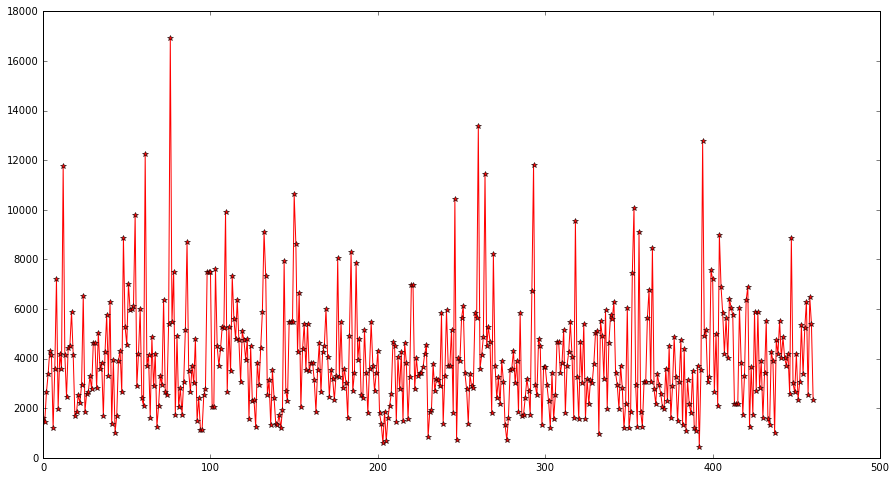

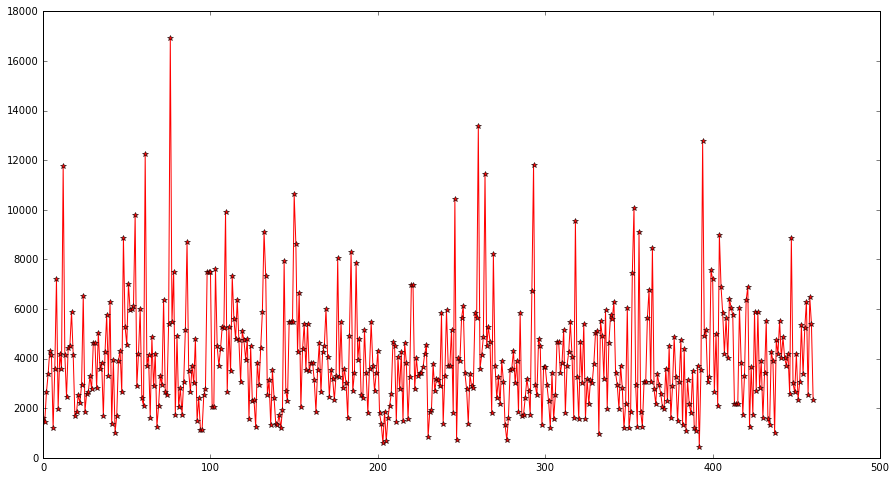

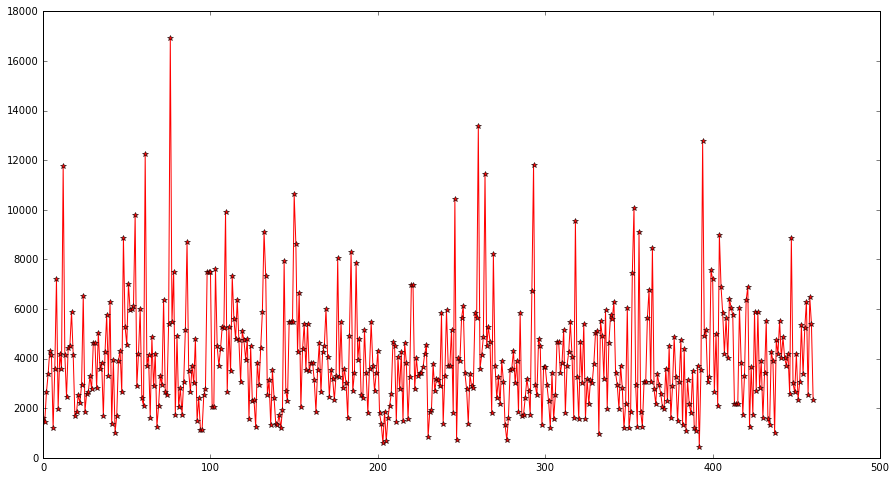

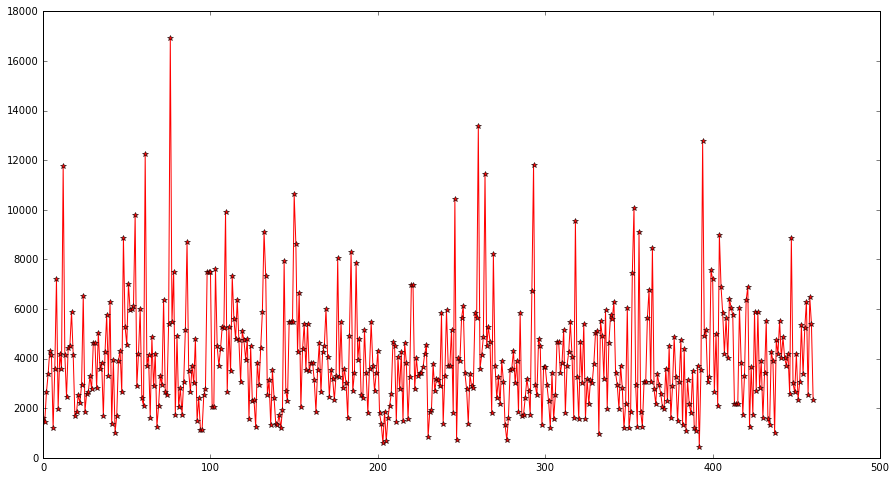

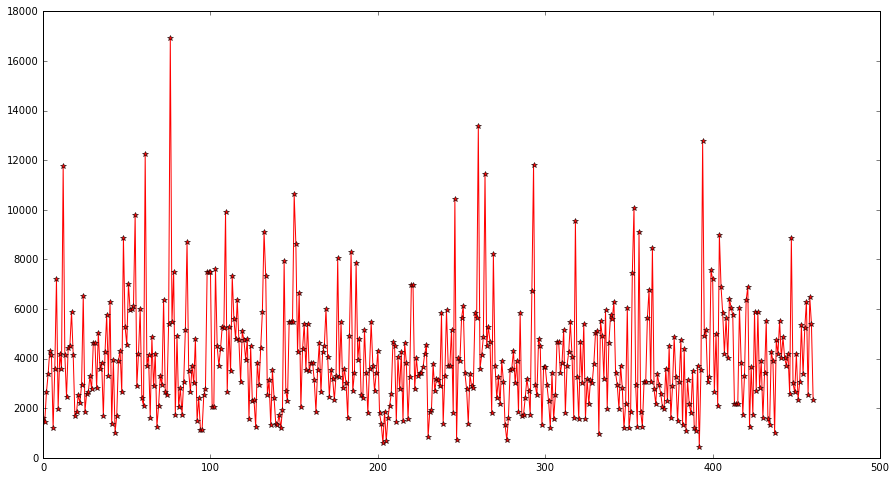

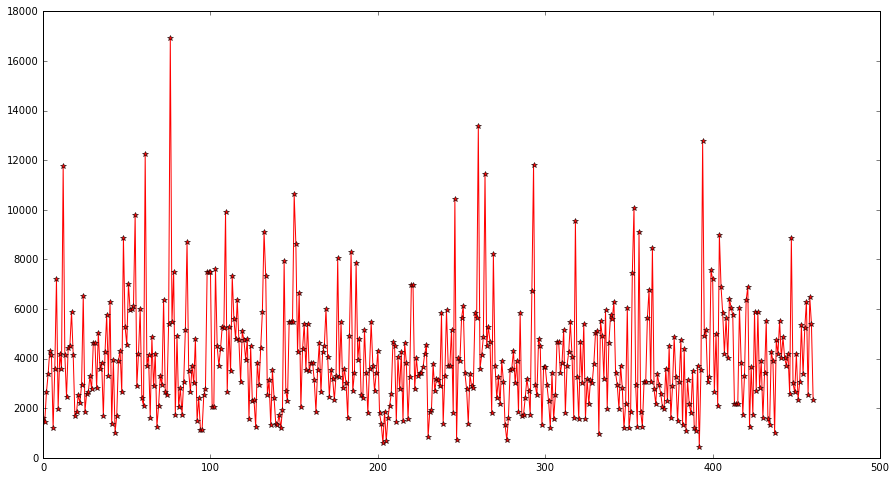

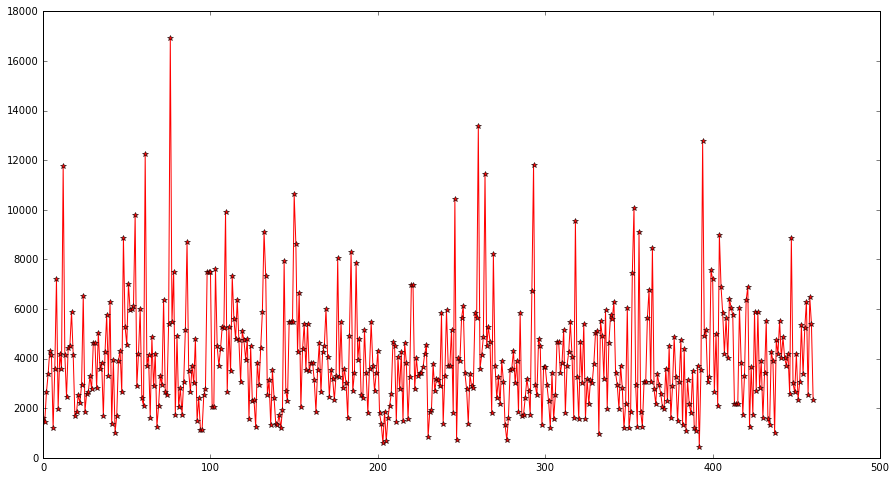

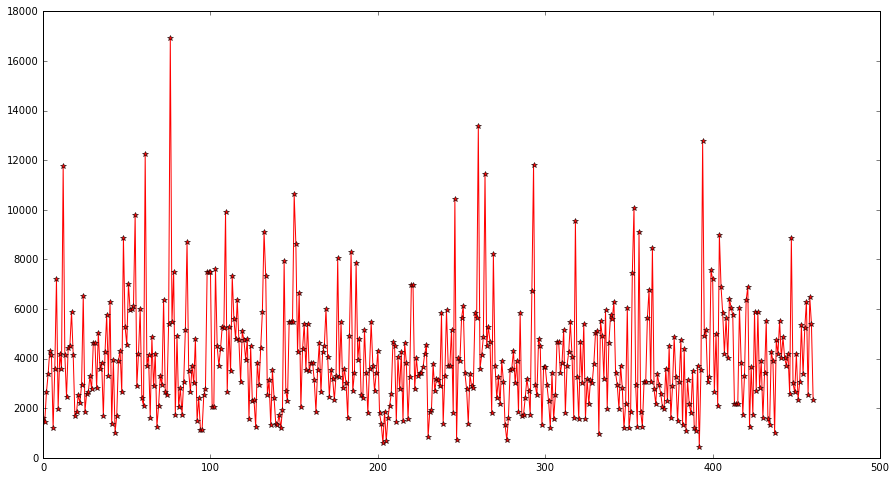

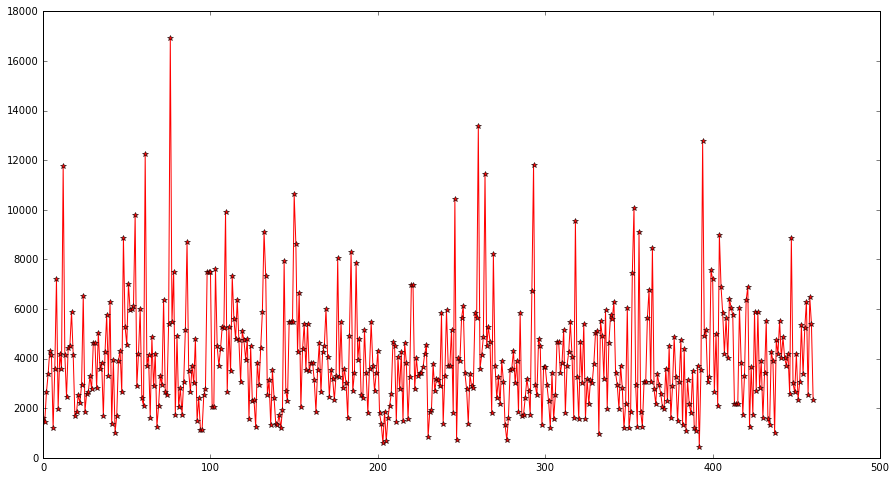

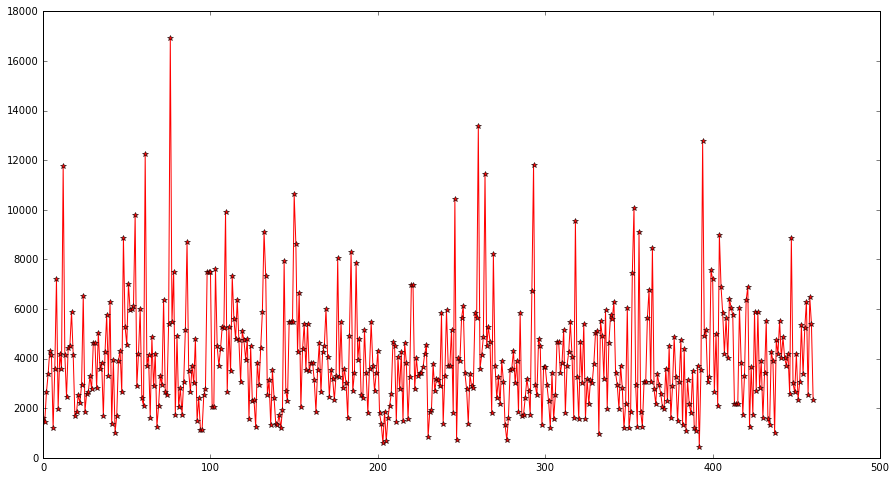

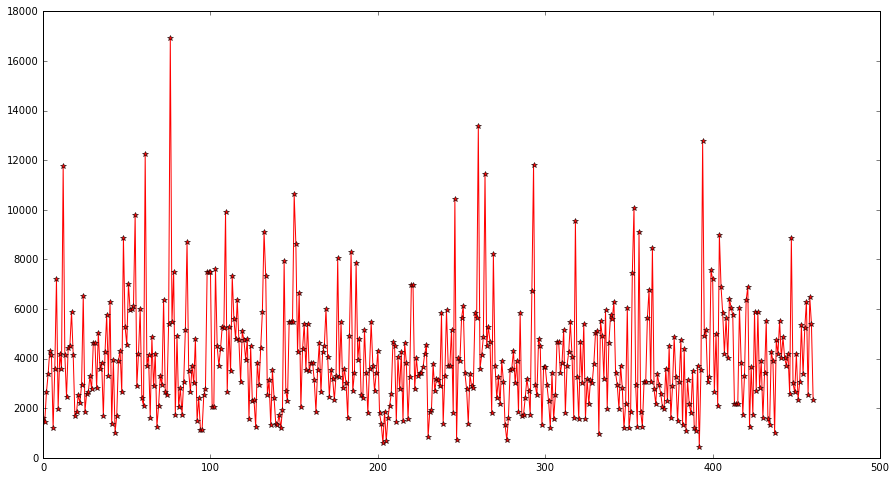

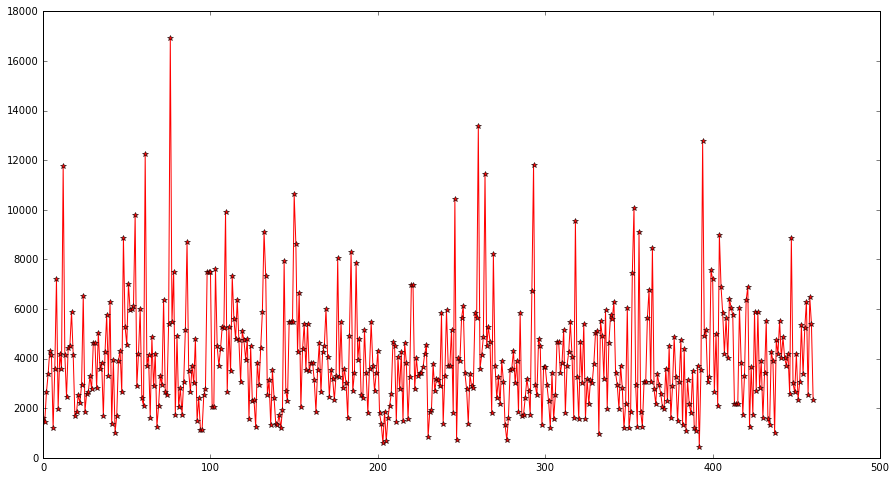

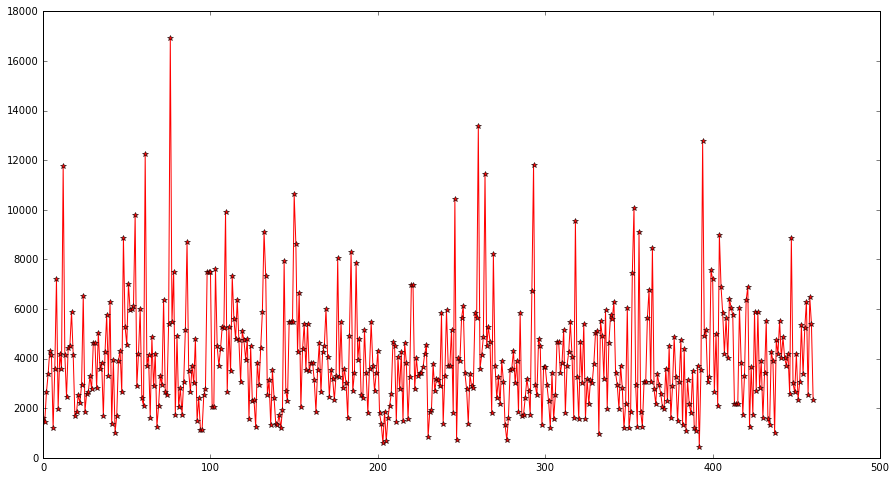

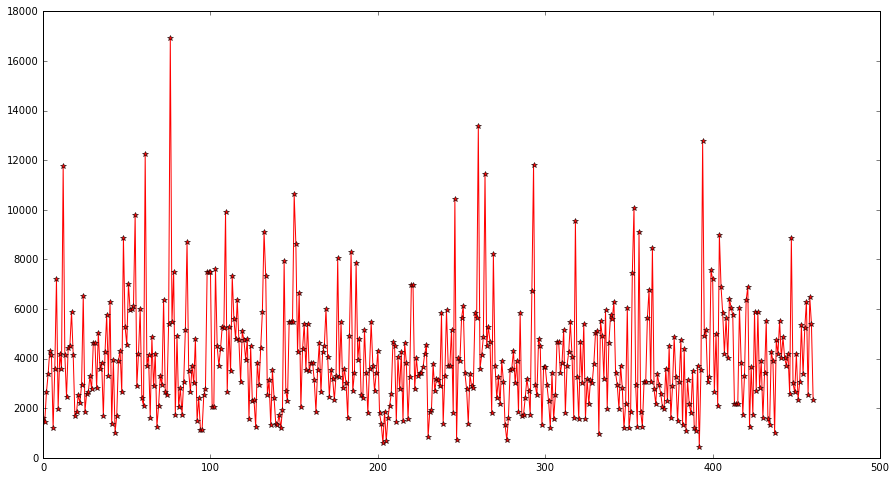

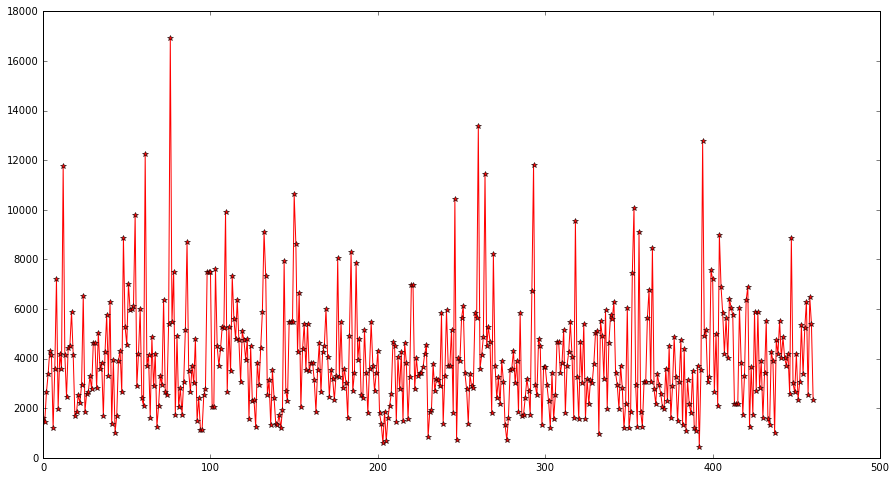

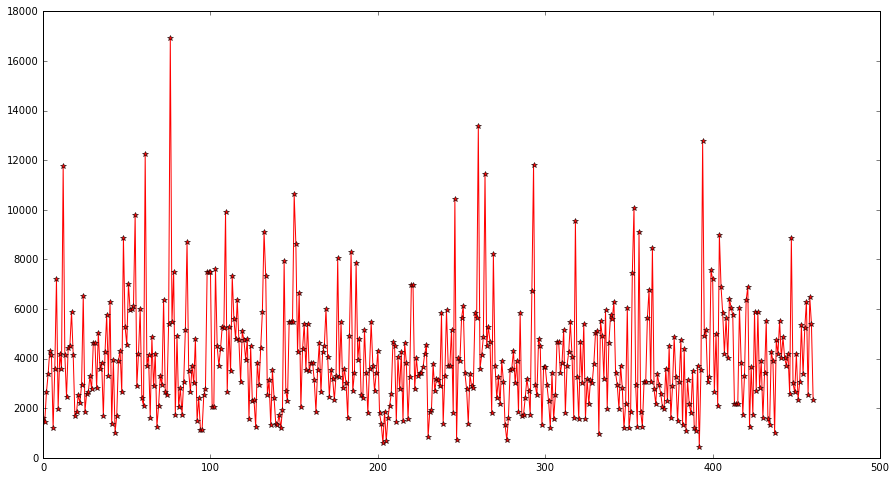

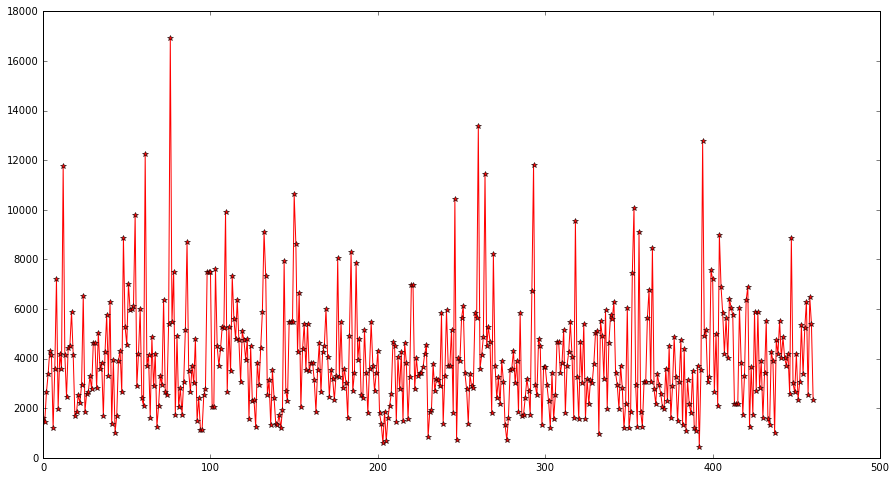

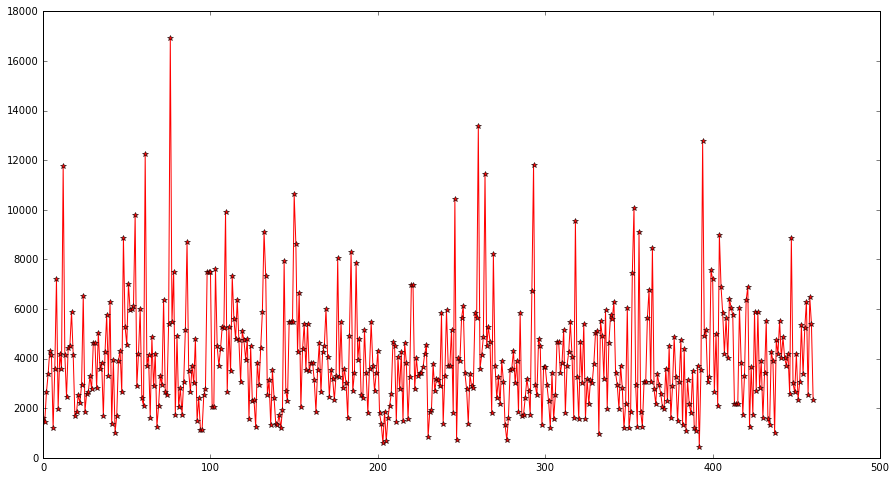

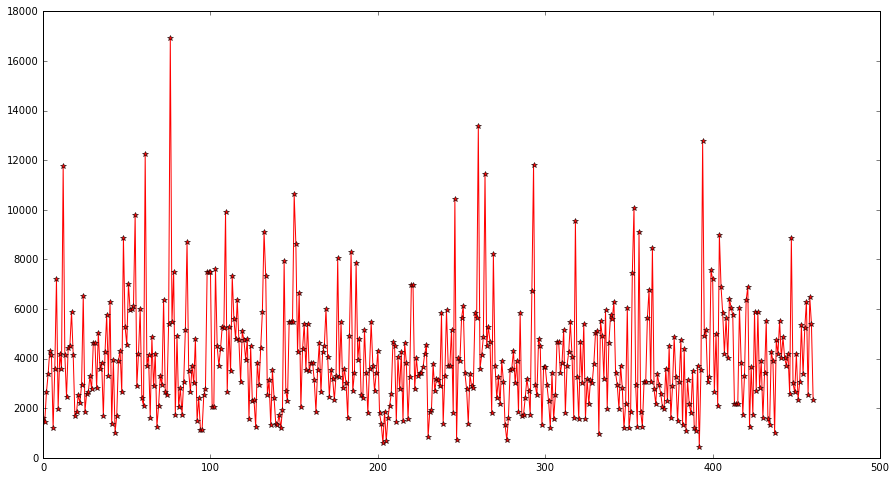

In [128]:
for md in range(1,20):
    print(md)
    model = tree.ExtraTreeRegressor(max_depth=md,min_samples_leaf=ms,random_state=42)
    model.fit(train[cols],train[target].values)
    res = model.predict(test[cols])
    print('quality-L1 ',quality(test[target].values, res))
    print('R^2 ',model.score(test[cols],test[target].values))
    print('mape ',mape(list(test[target].values), list(res)))
    print('mean diff in minute ',np.mean((pd.Series(test[target].values) - pd.Series(res))/60))
    plt.figure(figsize=[15,8])
    plt.plot(test[target].values,'-*r')
    print('***')
    #print('TTTTT')
    #plt.plot(res,'*b')

In [ ]:
import sklearn.metrics as mtr

df_temp = df.sort_values('time_of_expected')
df_temp = df_temp[3:df.shape[0]-1]

lrs = []
ests = []
max_depths = []
qs = []

for learning_rate in tqdm(range(1,301,5)):
    learning_rate = learning_rate / 1000.
    for est in tqdm(list(range(1,10))+list(range(10,100,10))+list(range(100,500,50))+list(range(500,1001,100))):
        strs = []
        for max_depth in list(range(1,10))+list(range(10,50,5))+list(range(50,150,10)):
        #for max_depth in tqdm(list(range(1,10))):
            model = ens.GradientBoostingRegressor(learning_rate = learning_rate,
                                                  n_estimators=est,max_depth=max_depth,random_state=42)
            res = cv.cross_val_predict(model, df_temp[cols],df_temp[target].values,cv = 5,n_jobs=-1)
            q = quality(df_temp[target],res)
            
            qs.append(q)
            lrs.append(learning_rate)
            ests.append(est)
            max_depths.append(max_depth)
            
            strs.append([q,learning_rate,est,max_depth])
            
        d = {'quality':qs,'learning_rate':lrs,'est':ests,'max_depth':max_depths}
        df_result = pd.DataFrame(d)
        df_result.to_csv('result_of_research(GradientBoostingRegressor).csv',index = False)
        #print(t.tabulate(strs))

# Градиентный бустинг

In [256]:
df_temp = df.sort_values('time_of_expected')
df_temp = df_temp[4:df.shape[0]-3]
date_threshold_1 = datetime.strptime('15.02.2015','%d.%m.%Y')
train = df_temp[df_temp.Arrive < date_threshold_1]
test = df_temp[df_temp.Arrive >= date_threshold_1]
train = train.sort_values('Arrive')
test = test.sort_values('Arrive')

In [311]:
import sklearn.ensemble as ens

  0%|          | 0/49 [00:00<?, ?it/s]

{'mape': 48.314735745270816, 'R^2': -0.0092063207975987549, 'mae': 1482.8325870521619, 'mean diff in minute': 7.553602222533694, 'mse': 4479895.3860245664, 'quality-L2': 0.23323585385040105, 'quality-L1': 0.38585419503368895}
{'mape': 47.1534240633804, 'R^2': 0.026497084401791771, 'mae': 1445.0146243527211, 'mean diff in minute': 7.168558674588563, 'mse': 4321406.9610891137, 'quality-L2': 0.22498450422501837, 'quality-L1': 0.37601342158250967}


  4%|▍         | 2/49 [00:00<00:05,  9.16it/s]

{'mape': 46.253046682502614, 'R^2': 0.052428335437506912, 'mae': 1417.6515666283467, 'mean diff in minute': 6.879206351118884, 'mse': 4206297.4047231432, 'quality-L2': 0.21899157953550172, 'quality-L1': 0.3688931635681586}


  6%|▌         | 3/49 [00:00<00:05,  7.86it/s]

{'mape': 45.47516578631274, 'R^2': 0.075924436649857041, 'mae': 1392.4982374062215, 'mean diff in minute': 6.557843760370971, 'mse': 4101997.5472593252, 'quality-L2': 0.21356143793265556, 'quality-L1': 0.3623479084367525}


  8%|▊         | 4/49 [00:00<00:06,  6.59it/s]

{'mape': 44.940559162, 'R^2': 0.09220813145788509, 'mae': 1376.7762525312246, 'mean diff in minute': 6.30565901271916, 'mse': 4029713.76570288, 'quality-L2': 0.20979814257458895, 'quality-L1': 0.35825682366343076}


 10%|█         | 5/49 [00:00<00:07,  5.53it/s]

{'mape': 44.354570472159246, 'R^2': 0.10645413750554367, 'mae': 1360.7717763755718, 'mean diff in minute': 6.124989582225294, 'mse': 3966475.342154616, 'quality-L2': 0.20650577379328974, 'quality-L1': 0.35409223062852063}


 12%|█▏        | 6/49 [00:01<00:09,  4.71it/s]

{'mape': 44.00219882279622, 'R^2': 0.11951174503714235, 'mae': 1348.9121001691472, 'mean diff in minute': 5.818864195724583, 'mse': 3908512.2532125083, 'quality-L2': 0.2034880536511202, 'quality-L1': 0.3510061736751269}


 14%|█▍        | 7/49 [00:01<00:10,  4.06it/s]

{'mape': 43.641920468726035, 'R^2': 0.12896879928017502, 'mae': 1339.6947100431557, 'mean diff in minute': 5.6679051779853395, 'mse': 3866532.1220979285, 'quality-L2': 0.20130245088999227, 'quality-L1': 0.34860767725791186}


 16%|█▋        | 8/49 [00:01<00:11,  3.55it/s]

{'mape': 43.313489804681474, 'R^2': 0.13690199157633465, 'mae': 1330.7942527197386, 'mean diff in minute': 5.515871325090997, 'mse': 3831316.4572416847, 'quality-L2': 0.19946902511686376, 'quality-L1': 0.34629165127767186}


 18%|█▊        | 9/49 [00:02<00:12,  3.15it/s]

{'mape': 43.15094006949835, 'R^2': 0.14312165892521289, 'mae': 1326.6124001721137, 'mean diff in minute': 5.328337454626135, 'mse': 3803707.1780639379, 'quality-L2': 0.1980316090059197, 'quality-L1': 0.3452034735814146}


 20%|██        | 10/49 [00:02<00:13,  2.82it/s]

{'mape': 42.975560255913805, 'R^2': 0.14875183181318641, 'mae': 1321.2184445760372, 'mean diff in minute': 5.159230390636131, 'mse': 3778714.6814618367, 'quality-L2': 0.19673042989735628, 'quality-L1': 0.34379988937862244}


 22%|██▏       | 11/49 [00:03<00:14,  2.55it/s]

{'mape': 42.72868410481543, 'R^2': 0.15298005324934927, 'mae': 1317.1066042943016, 'mean diff in minute': 5.092043635116984, 'mse': 3759945.4869843526, 'quality-L2': 0.19575325326200546, 'quality-L1': 0.3427299298728293}


 24%|██▍       | 12/49 [00:03<00:15,  2.32it/s]

{'mape': 42.6283832987074, 'R^2': 0.15741412023789114, 'mae': 1313.4720626346175, 'mean diff in minute': 4.92968596215573, 'mse': 3740262.5382810649, 'quality-L2': 0.194728504032051, 'quality-L1': 0.3417841702782138}


 27%|██▋       | 13/49 [00:04<00:16,  2.14it/s]

{'mape': 42.42125284316531, 'R^2': 0.15930230346977736, 'mae': 1311.3503911247533, 'mean diff in minute': 4.914235091728097, 'mse': 3731880.839540008, 'quality-L2': 0.1942921294085082, 'quality-L1': 0.34123208108101544}


 29%|██▊       | 14/49 [00:04<00:17,  1.98it/s]

{'mape': 42.450239475218616, 'R^2': 0.16310022504956012, 'mae': 1310.6566693882453, 'mean diff in minute': 4.614960578997786, 'mse': 3715021.7582886098, 'quality-L2': 0.1934143985974118, 'quality-L1': 0.34105156478770254}


 31%|███       | 15/49 [00:05<00:18,  1.84it/s]

{'mape': 42.67282996807535, 'R^2': 0.16816996472873091, 'mae': 1310.1072655981004, 'mean diff in minute': 3.996618770963752, 'mse': 3692517.040542576, 'quality-L2': 0.19224274019763452, 'quality-L1': 0.34090860208304863}


 33%|███▎      | 16/49 [00:06<00:19,  1.72it/s]

{'mape': 42.65826092661216, 'R^2': 0.17011035418534382, 'mae': 1309.6357919159093, 'mean diff in minute': 3.8237803444235667, 'mse': 3683903.5968942042, 'quality-L2': 0.19179430028758923, 'quality-L1': 0.3407859179043286}


 35%|███▍      | 17/49 [00:06<00:19,  1.62it/s]

{'mape': 42.68277307677296, 'R^2': 0.17088494478210881, 'mae': 1309.0899934655831, 'mean diff in minute': 3.729354328325903, 'mse': 3680465.1673392216, 'quality-L2': 0.19161528605085895, 'quality-L1': 0.34064389336053347}


 37%|███▋      | 18/49 [00:07<00:20,  1.52it/s]

{'mape': 42.62642828992389, 'R^2': 0.17279644568234132, 'mae': 1307.7275802302688, 'mean diff in minute': 3.5951089185304244, 'mse': 3671979.9608092369, 'quality-L2': 0.1911735225230116, 'quality-L1': 0.34028937399886994}


 39%|███▉      | 19/49 [00:08<00:20,  1.44it/s]

{'mape': 42.55468327301545, 'R^2': 0.17249579974408025, 'mae': 1307.8826382253139, 'mean diff in minute': 3.611677132815343, 'mse': 3673314.5366277662, 'quality-L2': 0.19124300426393215, 'quality-L1': 0.34032972230142544}


 41%|████      | 20/49 [00:09<00:21,  1.37it/s]

{'mape': 42.59097427196672, 'R^2': 0.17362460931466872, 'mae': 1308.9344056944965, 'mean diff in minute': 3.4194937429230254, 'mse': 3668303.7190350033, 'quality-L2': 0.19098212711859036, 'quality-L1': 0.34060340720269294}


 43%|████▎     | 21/49 [00:10<00:21,  1.30it/s]

{'mape': 42.534807895127344, 'R^2': 0.17385688274070521, 'mae': 1308.3744450293998, 'mean diff in minute': 3.4064820295266998, 'mse': 3667272.6507309778, 'quality-L2': 0.19092844682573845, 'quality-L1': 0.34045769744855925}


 45%|████▍     | 22/49 [00:10<00:21,  1.24it/s]

{'mape': 42.37748993529905, 'R^2': 0.17393123879844086, 'mae': 1307.2842807590193, 'mean diff in minute': 3.512450019598302, 'mse': 3666942.5820888099, 'quality-L2': 0.19091126253125135, 'quality-L1': 0.34017402115180423}


 47%|████▋     | 23/49 [00:11<00:21,  1.19it/s]

{'mape': 42.31851527948423, 'R^2': 0.17532524362567825, 'mae': 1307.0329210684654, 'mean diff in minute': 3.491766506115248, 'mse': 3660754.5552553064, 'quality-L2': 0.19058909658812162, 'quality-L1': 0.34010861377412105}


 49%|████▉     | 24/49 [00:12<00:21,  1.14it/s]

{'mape': 42.28335314582641, 'R^2': 0.17572414362773758, 'mae': 1306.4947646881456, 'mean diff in minute': 3.4627842456951736, 'mse': 3658983.8268701546, 'quality-L2': 0.1904969075276053, 'quality-L1': 0.33996857780597173}


 51%|█████     | 25/49 [00:13<00:21,  1.09it/s]

{'mape': 42.242385756677145, 'R^2': 0.17667314757225727, 'mae': 1306.0252158273959, 'mean diff in minute': 3.473576072519981, 'mse': 3654771.1715342142, 'quality-L2': 0.19027758493643038, 'quality-L1': 0.3398463944932529}


 53%|█████▎    | 26/49 [00:14<00:21,  1.05it/s]

{'mape': 42.32905552538524, 'R^2': 0.17697518014075608, 'mae': 1307.7315307308554, 'mean diff in minute': 3.3032291915621825, 'mse': 3653430.4404248632, 'quality-L2': 0.19020778273389452, 'quality-L1': 0.3402904019754852}


 55%|█████▌    | 27/49 [00:15<00:21,  1.02it/s]

{'mape': 42.34797316689211, 'R^2': 0.1766878765947536, 'mae': 1307.9287663022508, 'mean diff in minute': 3.2986663774957385, 'mse': 3654705.7889869963, 'quality-L2': 0.19027418093858822, 'quality-L1': 0.3403417254851632}


 57%|█████▋    | 28/49 [00:16<00:21,  1.02s/it]

{'mape': 42.31085562430814, 'R^2': 0.17719356797354435, 'mae': 1307.1067824395582, 'mean diff in minute': 3.260069007422466, 'mse': 3652461.0106617808, 'quality-L2': 0.19015731151547208, 'quality-L1': 0.34012783355667464}


 59%|█████▉    | 29/49 [00:18<00:20,  1.05s/it]

{'mape': 42.36471106257436, 'R^2': 0.17813480539529825, 'mae': 1307.5325610378572, 'mean diff in minute': 3.1191088376585023, 'mse': 3648282.8311399403, 'quality-L2': 0.18993978383137525, 'quality-L1': 0.34023862722262493}


 61%|██████    | 30/49 [00:19<00:20,  1.08s/it]

{'mape': 42.413866479867934, 'R^2': 0.17832141209847296, 'mae': 1308.2444482778692, 'mean diff in minute': 3.0775725915119128, 'mse': 3647454.4787095939, 'quality-L2': 0.1898966574925363, 'quality-L1': 0.34042387043911976}


 63%|██████▎   | 31/49 [00:20<00:20,  1.12s/it]

{'mape': 42.379294087786015, 'R^2': 0.18013657860259902, 'mae': 1306.2380108561929, 'mean diff in minute': 2.9750678233167327, 'mse': 3639396.9032870834, 'quality-L2': 0.18947715763334394, 'quality-L1': 0.3399017667957377}


 65%|██████▌   | 32/49 [00:21<00:19,  1.15s/it]

{'mape': 42.4796971044792, 'R^2': 0.18041169417012426, 'mae': 1307.1295333918199, 'mean diff in minute': 2.857841674951345, 'mse': 3638175.6575059374, 'quality-L2': 0.18941357617038937, 'quality-L1': 0.3401337536790463}


 67%|██████▋   | 33/49 [00:22<00:18,  1.18s/it]

{'mape': 42.46317794063242, 'R^2': 0.18011113193980299, 'mae': 1307.7122334268963, 'mean diff in minute': 2.8412126245383615, 'mse': 3639509.8617425552, 'quality-L2': 0.18948303856571888, 'quality-L1': 0.3402853805416763}


 69%|██████▉   | 34/49 [00:24<00:18,  1.21s/it]

{'mape': 42.77363345719443, 'R^2': 0.18270931377557886, 'mae': 1310.3230847243804, 'mean diff in minute': 2.498065209277923, 'mse': 3627976.4591287603, 'quality-L2': 0.18888257744450124, 'quality-L1': 0.3409647612988436}


 71%|███████▏  | 35/49 [00:25<00:17,  1.25s/it]

{'mape': 42.65693799524199, 'R^2': 0.18431827597184558, 'mae': 1306.8351512907122, 'mean diff in minute': 2.5407069578968495, 'mse': 3620834.2304577725, 'quality-L2': 0.18851073309124494, 'quality-L1': 0.34005715125632674}


 73%|███████▎  | 36/49 [00:26<00:16,  1.28s/it]

{'mape': 42.64066710025665, 'R^2': 0.18369021692460152, 'mae': 1306.5978763399871, 'mean diff in minute': 2.55219243238047, 'mse': 3623622.2023223122, 'quality-L2': 0.18865588268566763, 'quality-L1': 0.33999540892889657}


 76%|███████▌  | 37/49 [00:28<00:15,  1.31s/it]

{'mape': 42.62628066763906, 'R^2': 0.18326872683975282, 'mae': 1307.1287953057245, 'mean diff in minute': 2.542965525343671, 'mse': 3625493.2087235367, 'quality-L2': 0.18875329249950162, 'quality-L1': 0.3401335616185138}


 78%|███████▊  | 38/49 [00:29<00:14,  1.34s/it]

{'mape': 42.63482437173478, 'R^2': 0.18567318636830099, 'mae': 1304.9962965095845, 'mean diff in minute': 2.3660746495905673, 'mse': 3614819.7449076222, 'quality-L2': 0.18819760219155132, 'quality-L1': 0.3395786550069518}


 80%|███████▉  | 39/49 [00:31<00:13,  1.38s/it]

{'mape': 42.62784526612451, 'R^2': 0.18564542575747867, 'mae': 1304.9499788032217, 'mean diff in minute': 2.3732972508338803, 'mse': 3614942.9750437923, 'quality-L2': 0.1882040178962834, 'quality-L1': 0.3395666024789316}


 82%|████████▏ | 40/49 [00:32<00:12,  1.41s/it]

{'mape': 42.62211835651208, 'R^2': 0.18535345914832169, 'mae': 1305.3536220487506, 'mean diff in minute': 2.392612245612689, 'mse': 3616239.0230750828, 'quality-L2': 0.18827149377309818, 'quality-L1': 0.33967163621028057}


 84%|████████▎ | 41/49 [00:34<00:11,  1.43s/it]

{'mape': 42.61910715174416, 'R^2': 0.18530294701174455, 'mae': 1305.2638243345168, 'mean diff in minute': 2.3914149312656763, 'mse': 3616463.2478772136, 'quality-L2': 0.18828316754194177, 'quality-L1': 0.33964826956387406}


 86%|████████▌ | 42/49 [00:35<00:10,  1.46s/it]

{'mape': 42.58307457626254, 'R^2': 0.18693542017783205, 'mae': 1303.3305987406568, 'mean diff in minute': 2.378178649042719, 'mse': 3609216.6533465888, 'quality-L2': 0.1879058896108254, 'quality-L1': 0.33914521668261816}


 88%|████████▊ | 43/49 [00:37<00:08,  1.49s/it]

{'mape': 42.57482896456011, 'R^2': 0.18608758497305566, 'mae': 1304.7236835611761, 'mean diff in minute': 2.4116922998470582, 'mse': 3612980.2177869948, 'quality-L2': 0.18810183127690006, 'quality-L1': 0.3395077172283499}


 90%|████████▉ | 44/49 [00:38<00:07,  1.52s/it]

{'mape': 43.27249696743227, 'R^2': 0.18084321210558729, 'mae': 1315.0599612664266, 'mean diff in minute': 1.862369339348284, 'mse': 3636260.1371923708, 'quality-L2': 0.18931384883807323, 'quality-L1': 0.34219736415709234}


 92%|█████████▏| 45/49 [00:40<00:06,  1.56s/it]

{'mape': 43.2461201064263, 'R^2': 0.18096409756630161, 'mae': 1314.8138435020678, 'mean diff in minute': 1.9167811588531583, 'mse': 3635723.5232150983, 'quality-L2': 0.1892859112171266, 'quality-L1': 0.3421333208033923}


 94%|█████████▍| 46/49 [00:42<00:04,  1.59s/it]

{'mape': 43.314210089258516, 'R^2': 0.18064577898746526, 'mae': 1315.3675335559565, 'mean diff in minute': 1.811938191951302, 'mse': 3637136.548384707, 'quality-L2': 0.18935947725015806, 'quality-L1': 0.3422773988550261}


 96%|█████████▌| 47/49 [00:43<00:03,  1.62s/it]

{'mape': 43.328854080105316, 'R^2': 0.18068789469255253, 'mae': 1315.4825488806716, 'mean diff in minute': 1.7975507438230516, 'mse': 3636949.595579308, 'quality-L2': 0.1893497439654627, 'quality-L1': 0.34230732748346476}


 98%|█████████▊| 48/49 [00:45<00:01,  1.66s/it]

{'mape': 43.27365697146328, 'R^2': 0.18090108105744251, 'mae': 1314.3629223124831, 'mean diff in minute': 1.792656650034467, 'mse': 3636003.2552792598, 'quality-L2': 0.1893004748489108, 'quality-L1': 0.3420159846764759}


100%|██████████| 49/49 [00:47<00:00,  1.69s/it]


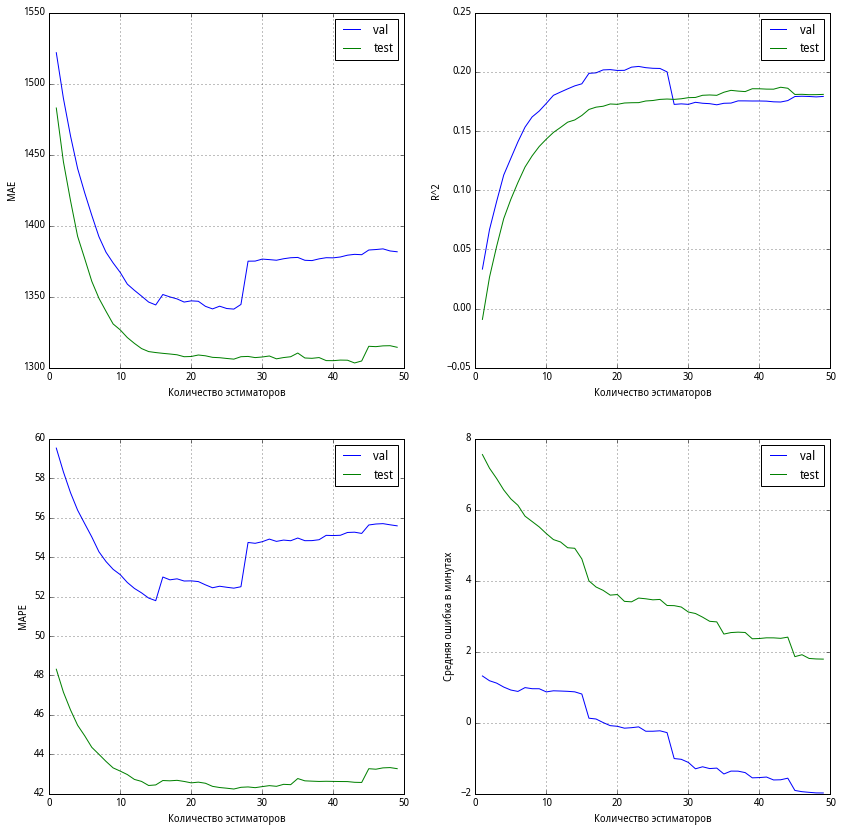

In [333]:
plt.figure(figsize=[10,10])
t_1 = []
t_2 = []
t_3 = []
t_4 = []
t_1_ = []
t_2_ = []
t_3_ = []
t_4_ = []
n = 50
for est in tqdm(range(1,n)):
    model = ens.GradientBoostingRegressor(loss = 'ls',n_estimators=est,random_state=42)
    model.fit(train[cols],train[target].values)
    res = model.predict(val[cols])
    res_test = model.predict(test[cols])
    t_1.append(mean_absolute_error(val[target].values, res))
    t_2.append(model.score(val[cols],val[target].values))
    t_3.append((mape(list(val[target].values), list(res))))
    t_4.append(np.mean((pd.Series(val[target].values) - pd.Series(res))/60))
    
    t_1_.append(mean_absolute_error(test[target].values, res_test))
    t_2_.append(model.score(test[cols],test[target].values))
    t_3_.append((mape(list(test[target].values), list(res_test))))
    t_4_.append(np.mean((pd.Series(test[target].values) - pd.Series(res_test))/60))
    print(results(test[target].values, res_test))
plt.figure(figsize=[14,14])
plt.subplot(221)
plt.grid(True)
plt.plot(range(1,n),t_1)
plt.plot(range(1,n),t_1_)
plt.legend(['val','test'])
plt.xlabel('Количество эстиматоров')
plt.ylabel('MAE')
plt.subplot(222)
plt.grid(True)
plt.plot(range(1,n),t_2)
plt.plot(range(1,n),t_2_)
plt.legend(['val','test'])
plt.ylabel('R^2')
plt.xlabel('Количество эстиматоров')
plt.subplot(223)
plt.grid(True)
plt.plot(range(1,n),t_3)
plt.plot(range(1,n),t_3_)
plt.legend(['val','test'])
plt.ylabel('MAPE')
plt.xlabel('Количество эстиматоров')
plt.subplot(224)
plt.plot(range(1,n),t_4)
plt.plot(range(1,n),t_4_)
plt.legend(['val','test'])
plt.ylabel('Средняя ошибка в минутах')
plt.xlabel('Количество эстиматоров')
plt.grid(True)

  0%|          | 0/24 [00:00<?, ?it/s]

{'mape': 41.68171820875236, 'R^2': -0.061590223796262, 'mae': 1463.51889233624, 'mean diff in minute': 13.477290484977845, 'mse': 4712429.0122113321, 'quality-L2': 0.24534220325797665, 'quality-L1': 0.3808284961160829}


  4%|▍         | 1/24 [00:01<00:31,  1.36s/it]

{'mape': 39.967753563146914, 'R^2': 0.010533526021068274, 'mae': 1394.7243281376482, 'mean diff in minute': 12.176230816364374, 'mse': 4392269.647995213, 'quality-L2': 0.22867381343037108, 'quality-L1': 0.36292716900517136}


  8%|▊         | 2/24 [00:02<00:29,  1.36s/it]

{'mape': 38.98334366410763, 'R^2': 0.061888007547173163, 'mae': 1350.0188743499832, 'mean diff in minute': 11.037308034540027, 'mse': 4164305.6528245751, 'quality-L2': 0.21680537176393444, 'quality-L1': 0.35129417210755975}


 12%|█▎        | 3/24 [00:04<00:28,  1.36s/it]

{'mape': 38.48760545157148, 'R^2': 0.093166972632921841, 'mae': 1323.8963394644361, 'mean diff in minute': 10.180359669393232, 'mse': 4025457.4426225983, 'quality-L2': 0.20957654651879914, 'quality-L1': 0.3444967158346703}


 17%|█▋        | 4/24 [00:05<00:27,  1.36s/it]

{'mape': 38.23676847072418, 'R^2': 0.1061671389197647, 'mae': 1313.6026064413584, 'mean diff in minute': 9.677695435750687, 'mse': 3967749.3369896966, 'quality-L2': 0.20657210151917568, 'quality-L1': 0.3418181396392233}


 21%|██        | 5/24 [00:06<00:25,  1.36s/it]

{'mape': 38.091688263566994, 'R^2': 0.1137097884498447, 'mae': 1307.6304636193117, 'mean diff in minute': 9.378992087165491, 'mse': 3934267.3025118504, 'quality-L2': 0.2048289333808191, 'quality-L1': 0.3402641028711153}


 25%|██▌       | 6/24 [00:08<00:24,  1.36s/it]

{'mape': 38.04965519594741, 'R^2': 0.12302759394235752, 'mae': 1303.2659822720132, 'mean diff in minute': 9.050019944008648, 'mse': 3892905.3005370786, 'quality-L2': 0.20267551214744775, 'quality-L1': 0.33912840255558024}


 29%|██▉       | 7/24 [00:09<00:22,  1.35s/it]

{'mape': 38.32671652173326, 'R^2': 0.13688027728661367, 'mae': 1297.3230448150064, 'mean diff in minute': 8.253216606323155, 'mse': 3831412.8475875701, 'quality-L2': 0.19947404346722422, 'quality-L1': 0.33758196544013525}


 33%|███▎      | 8/24 [00:10<00:21,  1.34s/it]

{'mape': 38.112704629547814, 'R^2': 0.13011199791424966, 'mae': 1302.1560449717906, 'mean diff in minute': 8.7534873313331, 'mse': 3861457.4310456039, 'quality-L2': 0.20103824831412198, 'quality-L1': 0.3388395810343547}


 38%|███▊      | 9/24 [00:12<00:20,  1.34s/it]

{'mape': 38.08444284274219, 'R^2': 0.1310769053374099, 'mae': 1298.8141640140668, 'mean diff in minute': 8.639990518581259, 'mse': 3857174.1797184227, 'quality-L2': 0.20081525029866235, 'quality-L1': 0.3379699759298399}


 42%|████▏     | 10/24 [00:13<00:18,  1.32s/it]

{'mape': 37.847010331613276, 'R^2': 0.13366412764511526, 'mae': 1294.2044324819512, 'mean diff in minute': 8.546758673515166, 'mse': 3845689.426759534, 'quality-L2': 0.20021732201422454, 'quality-L1': 0.3367704580171797}


 46%|████▌     | 11/24 [00:14<00:16,  1.31s/it]

{'mape': 37.88667334802314, 'R^2': 0.12006255547624267, 'mae': 1307.158540908993, 'mean diff in minute': 9.079539064390566, 'mse': 3906067.1901031635, 'quality-L2': 0.20336075684329633, 'quality-L1': 0.3401413018488713}


 50%|█████     | 12/24 [00:15<00:15,  1.29s/it]

{'mape': 38.08326631205474, 'R^2': 0.12349815233529515, 'mae': 1304.8111579661215, 'mean diff in minute': 8.993238027280343, 'mse': 3890816.4785291958, 'quality-L2': 0.20256676224536968, 'quality-L1': 0.3395304793165322}


 54%|█████▍    | 13/24 [00:17<00:14,  1.28s/it]

{'mape': 38.30040614473745, 'R^2': 0.13059792218070099, 'mae': 1302.5328791666607, 'mean diff in minute': 8.461084945236461, 'mse': 3859300.3994908351, 'quality-L2': 0.20092594723271098, 'quality-L1': 0.3389376386682326}


 58%|█████▊    | 14/24 [00:18<00:12,  1.27s/it]

{'mape': 37.997100966315344, 'R^2': 0.12366571956384298, 'mae': 1301.0744130763921, 'mean diff in minute': 8.887599037389831, 'mse': 3890072.6428649211, 'quality-L2': 0.20252803608519537, 'quality-L1': 0.33855812498330284}


 62%|██████▎   | 15/24 [00:19<00:11,  1.26s/it]

{'mape': 38.312494331728296, 'R^2': 0.1302437310688962, 'mae': 1303.4855015402934, 'mean diff in minute': 8.490967820436834, 'mse': 3860872.663848327, 'quality-L2': 0.201007803702182, 'quality-L1': 0.3391855246011141}


 67%|██████▋   | 16/24 [00:20<00:09,  1.25s/it]

{'mape': 38.40506360297523, 'R^2': 0.12975982574922074, 'mae': 1310.4592539063092, 'mean diff in minute': 8.501482879208593, 'mse': 3863020.7332412866, 'quality-L2': 0.20111963818844222, 'quality-L1': 0.3410001944627349}


 71%|███████   | 17/24 [00:22<00:08,  1.24s/it]

{'mape': 38.387351262298594, 'R^2': 0.12339787628234256, 'mae': 1306.3039837556737, 'mean diff in minute': 8.738735791540414, 'mse': 3891261.6067628316, 'quality-L2': 0.20258993686323426, 'quality-L1': 0.3399189338854316}


 75%|███████▌  | 18/24 [00:23<00:07,  1.23s/it]

{'mape': 38.12274635734239, 'R^2': 0.13087977080491298, 'mae': 1304.9366955302744, 'mean diff in minute': 8.351752946569901, 'mse': 3858049.2654807284, 'quality-L2': 0.20086080970516096, 'quality-L1': 0.33956314598179516}


 79%|███████▉  | 19/24 [00:24<00:06,  1.22s/it]

{'mape': 37.881343512590455, 'R^2': 0.13470272147152607, 'mae': 1296.4236408151648, 'mean diff in minute': 8.41011262632824, 'mse': 3841079.0794053734, 'quality-L2': 0.19997729446691845, 'quality-L1': 0.33734792768739125}


 83%|████████▎ | 20/24 [00:25<00:04,  1.20s/it]

{'mape': 38.20370490950793, 'R^2': 0.13477627383930957, 'mae': 1298.9657117955937, 'mean diff in minute': 7.998942146705082, 'mse': 3840752.5783656221, 'quality-L2': 0.19996029591176742, 'quality-L1': 0.33800941082475744}


 88%|████████▊ | 21/24 [00:26<00:03,  1.20s/it]

{'mape': 38.49273378000163, 'R^2': 0.13848225897457156, 'mae': 1301.1164988043372, 'mean diff in minute': 7.6565159220401116, 'mse': 3824301.6055902885, 'quality-L2': 0.19910381236666203, 'quality-L1': 0.3385690762901607}


 92%|█████████▏| 22/24 [00:28<00:02,  1.19s/it]

{'mape': 38.09643880965064, 'R^2': 0.12422188534641132, 'mae': 1309.9429760682849, 'mean diff in minute': 8.92389643471969, 'mse': 3887603.8072345387, 'quality-L2': 0.20239950161359502, 'quality-L1': 0.34086585160343785}


 96%|█████████▌| 23/24 [00:29<00:01,  1.18s/it]

{'mape': 38.567811102320775, 'R^2': 0.12947163630460012, 'mae': 1303.9952665601572, 'mean diff in minute': 8.359401887649472, 'mse': 3864300.0143324276, 'quality-L2': 0.2011862411315685, 'quality-L1': 0.3393181727322067}


100%|██████████| 24/24 [00:30<00:00,  1.17s/it]


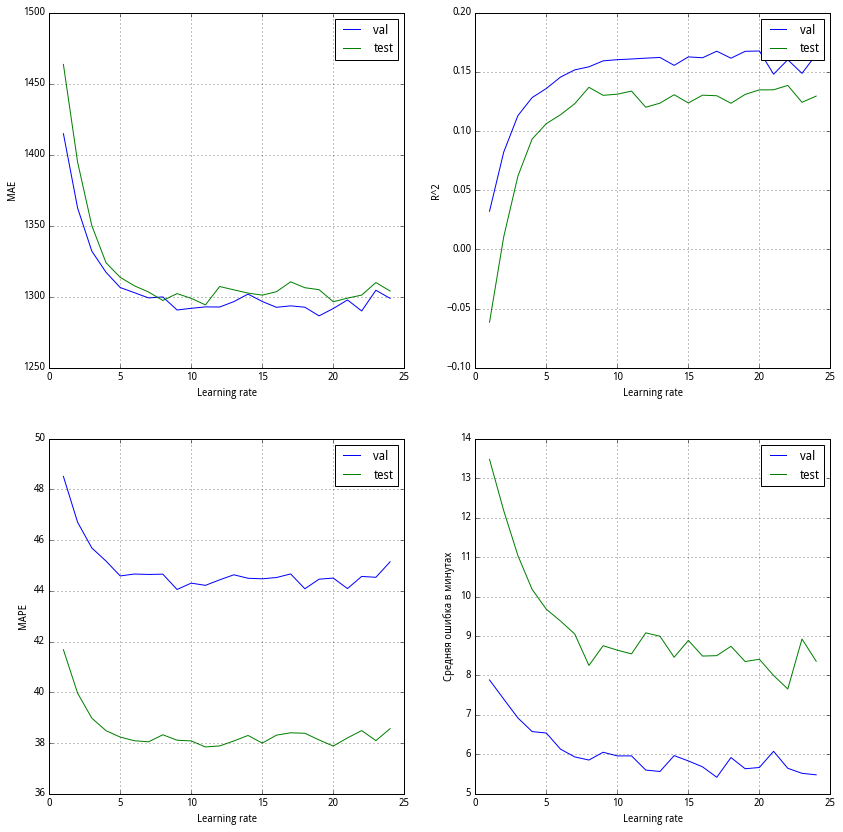

In [334]:
plt.figure(figsize=[10,10])
t_1 = []
t_2 = []
t_3 = []
t_4 = []
t_1_ = []
t_2_ = []
t_3_ = []
t_4_ = []
n = 25
for lr in tqdm(range(1,n)):
    lr = lr/100
    model = ens.GradientBoostingRegressor(loss = 'lad',n_estimators=33,learning_rate=lr,random_state=42)
    model.fit(train[cols],train[target].values)
    res = model.predict(val[cols])
    res_test = model.predict(test[cols])
    t_1.append(mean_absolute_error(val[target].values, res))
    t_2.append(model.score(val[cols],val[target].values))
    t_3.append((mape(list(val[target].values), list(res))))
    t_4.append(np.mean((pd.Series(val[target].values) - pd.Series(res))/60))
    
    t_1_.append(mean_absolute_error(test[target].values, res_test))
    t_2_.append(model.score(test[cols],test[target].values))
    t_3_.append((mape(list(test[target].values), list(res_test))))
    t_4_.append(np.mean((pd.Series(test[target].values) - pd.Series(res_test))/60))
    print(results(test[target].values, res_test))
plt.figure(figsize=[14,14])
plt.subplot(221)
plt.grid(True)
plt.plot(range(1,n),t_1)
plt.plot(range(1,n),t_1_)
plt.legend(['val','test'])
plt.xlabel('Learning rate')
plt.ylabel('MAE')
plt.subplot(222)
plt.grid(True)
plt.plot(range(1,n),t_2)
plt.plot(range(1,n),t_2_)
plt.legend(['val','test'])
plt.ylabel('R^2')
plt.xlabel('Learning rate')
plt.subplot(223)
plt.grid(True)
plt.plot(range(1,n),t_3)
plt.plot(range(1,n),t_3_)
plt.legend(['val','test'])
plt.ylabel('MAPE')
plt.xlabel('Learning rate')
plt.subplot(224)
plt.plot(range(1,n),t_4)
plt.plot(range(1,n),t_4_)
plt.legend(['val','test'])
plt.ylabel('Средняя ошибка в минутах')
plt.xlabel('Learning rate')
plt.grid(True)

  0%|          | 0/24 [00:00<?, ?it/s]

{'mape': 46.70263038248196, 'R^2': 0.039291913578592963, 'mae': 1431.5227357072602, 'mean diff in minute': 7.034031781151682, 'mse': 4264610.3526921077, 'quality-L2': 0.222027514314806, 'quality-L1': 0.3725026396653629}


  4%|▍         | 1/24 [00:01<00:24,  1.06s/it]

{'mape': 44.94142820715024, 'R^2': 0.092461246921095919, 'mae': 1376.6261883404534, 'mean diff in minute': 6.2957529751119, 'mse': 4028590.1790066799, 'quality-L2': 0.20973964551609048, 'quality-L1': 0.3582177748199948}


  8%|▊         | 2/24 [00:02<00:23,  1.07s/it]

{'mape': 43.833129126016686, 'R^2': 0.12575763214849789, 'mae': 1343.6699425500783, 'mean diff in minute': 5.692606036277474, 'mse': 3880786.583767951, 'quality-L2': 0.20204457793812744, 'quality-L1': 0.34964208947168673}


 12%|█▎        | 3/24 [00:03<00:22,  1.07s/it]

{'mape': 43.160872790685936, 'R^2': 0.14513229752947165, 'mae': 1325.3675692287818, 'mean diff in minute': 5.242233449628409, 'mse': 3794781.8964633802, 'quality-L2': 0.19756693394197591, 'quality-L1': 0.34487955080969607}


 17%|█▋        | 4/24 [00:04<00:21,  1.07s/it]

{'mape': 42.60404552151298, 'R^2': 0.15689983677712072, 'mae': 1314.1893869835756, 'mean diff in minute': 5.008450556918401, 'mse': 3742545.457101068, 'quality-L2': 0.19484735915574772, 'quality-L1': 0.34197082830802894}


 21%|██        | 5/24 [00:05<00:20,  1.07s/it]

{'mape': 42.395267488656565, 'R^2': 0.16600795230266141, 'mae': 1308.032951044351, 'mean diff in minute': 4.591322071803433, 'mse': 3702114.274817151, 'quality-L2': 0.19274239899270715, 'quality-L1': 0.3403688358414836}


 25%|██▌       | 6/24 [00:06<00:19,  1.06s/it]

{'mape': 42.49694260812847, 'R^2': 0.16911353615962588, 'mae': 1306.9646082325244, 'mean diff in minute': 3.7311842914720414, 'mse': 3688328.5002881805, 'quality-L2': 0.19202467310489205, 'quality-L1': 0.3400908377995757}


 29%|██▉       | 7/24 [00:07<00:18,  1.06s/it]

{'mape': 42.422691438095356, 'R^2': 0.17426976847530917, 'mae': 1307.0223066667197, 'mean diff in minute': 3.6461535553574658, 'mse': 3665439.839283715, 'quality-L2': 0.1908330255477812, 'quality-L1': 0.3401058517553488}


 33%|███▎      | 8/24 [00:08<00:16,  1.06s/it]

{'mape': 43.11945046680029, 'R^2': 0.16577336390075159, 'mae': 1321.8226524272145, 'mean diff in minute': 2.797584830335913, 'mse': 3703155.6193645177, 'quality-L2': 0.19279661429546105, 'quality-L1': 0.3439571128818585}


 38%|███▊      | 9/24 [00:09<00:15,  1.05s/it]

{'mape': 42.242385756677145, 'R^2': 0.17667314757225727, 'mae': 1306.0252158273959, 'mean diff in minute': 3.473576072519981, 'mse': 3654771.1715342142, 'quality-L2': 0.19027758493643038, 'quality-L1': 0.3398463944932529}


 42%|████▏     | 10/24 [00:10<00:14,  1.04s/it]

{'mape': 42.12307217062633, 'R^2': 0.17581199689281179, 'mae': 1303.4902983011068, 'mean diff in minute': 3.3865423073487304, 'mse': 3658593.8437430752, 'quality-L2': 0.1904766039178568, 'quality-L1': 0.3391867727867143}


 46%|████▌     | 11/24 [00:11<00:13,  1.03s/it]

{'mape': 42.439786374934805, 'R^2': 0.1750350671444757, 'mae': 1311.7805150064171, 'mean diff in minute': 3.073697354530478, 'mse': 3662042.6568580042, 'quality-L2': 0.19065615875169084, 'quality-L1': 0.3413440054516922}


 50%|█████     | 12/24 [00:12<00:12,  1.03s/it]

{'mape': 42.68647335543936, 'R^2': 0.17706473583325133, 'mae': 1306.0809680601158, 'mean diff in minute': 2.5882359863021858, 'mse': 3653032.9001743379, 'quality-L2': 0.19018708567921333, 'quality-L1': 0.3398609020196357}


 54%|█████▍    | 13/24 [00:13<00:11,  1.02s/it]

{'mape': 43.203084799090945, 'R^2': 0.17546442503554827, 'mae': 1311.8724566788073, 'mean diff in minute': 2.110330587683654, 'mse': 3660136.7250425462, 'quality-L2': 0.19055693062334064, 'quality-L1': 0.3413679299865989}


 58%|█████▊    | 14/24 [00:14<00:10,  1.01s/it]

{'mape': 42.73823366666106, 'R^2': 0.17734941513345148, 'mae': 1310.7382374929007, 'mean diff in minute': 2.42510401273867, 'mse': 3651769.2007135027, 'quality-L2': 0.1901212939592376, 'quality-L1': 0.3410727899722835}


 62%|██████▎   | 15/24 [00:15<00:09,  1.00s/it]

{'mape': 43.10568515505713, 'R^2': 0.17642628779582437, 'mae': 1310.8924949097816, 'mean diff in minute': 1.791310852193525, 'mse': 3655866.989059973, 'quality-L2': 0.19033463625443267, 'quality-L1': 0.3411129299529792}


 67%|██████▋   | 16/24 [00:16<00:07,  1.01it/s]

{'mape': 42.403566584957105, 'R^2': 0.18180976325410958, 'mae': 1303.4597679768376, 'mean diff in minute': 2.630453147892295, 'mse': 3631969.5893218424, 'quality-L2': 0.18909047094420814, 'quality-L1': 0.3391788283607568}


 71%|███████   | 17/24 [00:17<00:06,  1.01it/s]

{'mape': 45.44734587006622, 'R^2': 0.16822743532211026, 'mae': 1344.1252911812937, 'mean diff in minute': 0.3369610421871148, 'mse': 3692261.9269539998, 'quality-L2': 0.1922294582723811, 'quality-L1': 0.3497605776820832}


 75%|███████▌  | 18/24 [00:18<00:05,  1.02it/s]

{'mape': 43.62066579720597, 'R^2': 0.18338966461306971, 'mae': 1317.7988956179595, 'mean diff in minute': 1.7779986217470007, 'mse': 3624956.3625291432, 'quality-L2': 0.18872534278868347, 'quality-L1': 0.34291007395231055}


 79%|███████▉  | 19/24 [00:19<00:04,  1.03it/s]

{'mape': 43.79418053823401, 'R^2': 0.15912601151288697, 'mae': 1335.1816002695996, 'mean diff in minute': 1.2699215568030273, 'mse': 3732663.4045200236, 'quality-L2': 0.1943328719249242, 'quality-L1': 0.347433301705351}


 83%|████████▎ | 20/24 [00:20<00:03,  1.04it/s]

{'mape': 43.351681245916105, 'R^2': 0.15894667382808836, 'mae': 1328.0493066237843, 'mean diff in minute': 1.8234571937588675, 'mse': 3733459.4895723197, 'quality-L2': 0.1943743183340279, 'quality-L1': 0.3455773771407841}


 88%|████████▊ | 21/24 [00:21<00:02,  1.04it/s]

{'mape': 43.561420097466076, 'R^2': 0.16024151055094926, 'mae': 1328.5178627366113, 'mean diff in minute': 2.1942618700276744, 'mse': 3727711.6727574044, 'quality-L2': 0.19407507095276422, 'quality-L1': 0.34569930212632927}


 92%|█████████▏| 22/24 [00:22<00:01,  1.04it/s]

{'mape': 43.404593263279104, 'R^2': 0.16970420387571006, 'mae': 1323.4023349898196, 'mean diff in minute': 2.071722875819591, 'mse': 3685706.5095996284, 'quality-L2': 0.19188816495362152, 'quality-L1': 0.34436816882231}


 96%|█████████▌| 23/24 [00:23<00:00,  1.06it/s]

{'mape': 43.43586086897756, 'R^2': 0.16475416879952665, 'mae': 1329.3858912959347, 'mean diff in minute': 2.237497530684006, 'mse': 3707679.8552292199, 'quality-L2': 0.19303215863835263, 'quality-L1': 0.34592517554181074}


100%|██████████| 24/24 [00:24<00:00,  1.06it/s]


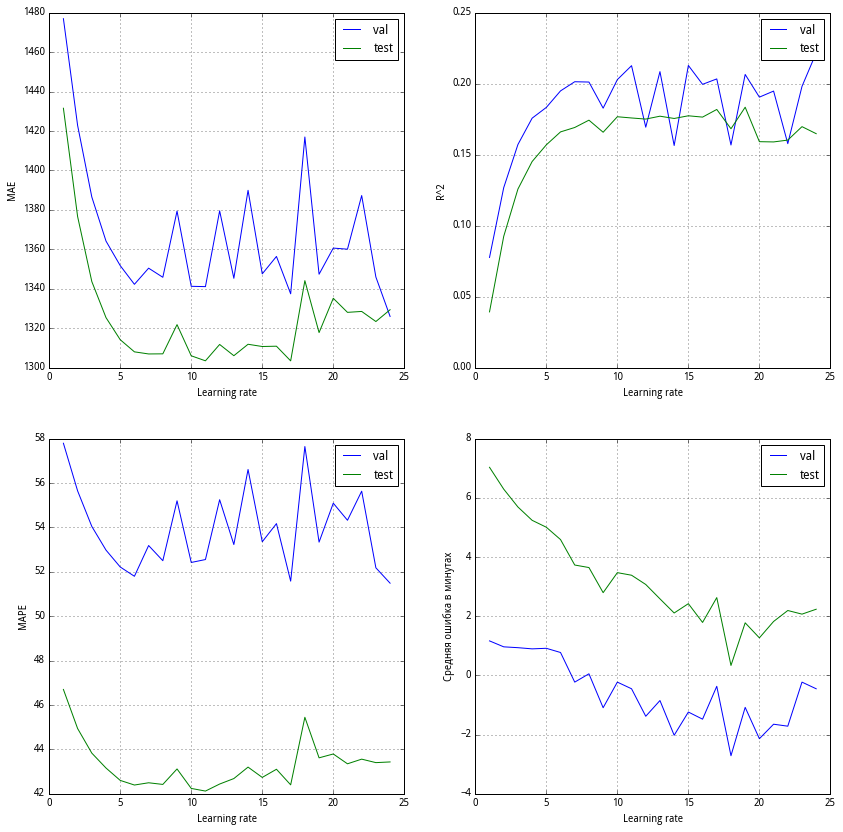

In [335]:
plt.figure(figsize=[10,10])
t_1 = []
t_2 = []
t_3 = []
t_4 = []
t_1_ = []
t_2_ = []
t_3_ = []
t_4_ = []
n = 25
for lr in tqdm(range(1,n)):
    lr = lr/100
    model = ens.GradientBoostingRegressor(loss = 'ls',n_estimators=26,learning_rate=lr,random_state=42)
    model.fit(train[cols],train[target].values)
    res = model.predict(val[cols])
    res_test = model.predict(test[cols])
    t_1.append(mean_absolute_error(val[target].values, res))
    t_2.append(model.score(val[cols],val[target].values))
    t_3.append((mape(list(val[target].values), list(res))))
    t_4.append(np.mean((pd.Series(val[target].values) - pd.Series(res))/60))
    
    t_1_.append(mean_absolute_error(test[target].values, res_test))
    t_2_.append(model.score(test[cols],test[target].values))
    t_3_.append((mape(list(test[target].values), list(res_test))))
    t_4_.append(np.mean((pd.Series(test[target].values) - pd.Series(res_test))/60))
    print(results(test[target].values, res_test))

plt.figure(figsize=[14,14])
plt.subplot(221)
plt.grid(True)
plt.plot(range(1,n),t_1)
plt.plot(range(1,n),t_1_)
plt.legend(['val','test'])
plt.xlabel('Learning rate')
plt.ylabel('MAE')
plt.subplot(222)
plt.grid(True)
plt.plot(range(1,n),t_2)
plt.plot(range(1,n),t_2_)
plt.legend(['val','test'])
plt.ylabel('R^2')
plt.xlabel('Learning rate')
plt.subplot(223)
plt.grid(True)
plt.plot(range(1,n),t_3)
plt.plot(range(1,n),t_3_)
plt.legend(['val','test'])
plt.ylabel('MAPE')
plt.xlabel('Learning rate')
plt.subplot(224)
plt.plot(range(1,n),t_4)
plt.plot(range(1,n),t_4_)
plt.legend(['val','test'])
plt.ylabel('Средняя ошибка в минутах')
plt.xlabel('Learning rate')
plt.grid(True)

In [257]:
import xgboost as xgb

In [261]:
import numpy as np

from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint

from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

In [367]:
def report(grid_scores, n_top=3,score = 'я не помню, что поставил'):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print('"'+str(score)+": {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(1, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["mse", "mse"]}

clf = ens.RandomForestRegressor()
# run randomized search
n_iter_search = 1000

In [336]:

random_search = RandomizedSearchCV(clf, param_distributions=param_dist,scoring='r2',n_iter=n_iter_search)

start = time()
random_search.fit(train[cols],train[target].values)
report(random_search.grid_scores_,3, 'R^2')

Model with rank: 1
"mean: 0.19396, std: 0.00202, params: {'max_depth': None, 'min_samples_split': 8, 'criterion': 'mse', 'min_samples_leaf': 8, 'bootstrap': False, 'max_features': 9}: 0.194 (std: 0.002)
Parameters: {'max_depth': None, 'min_samples_split': 8, 'criterion': 'mse', 'min_samples_leaf': 8, 'bootstrap': False, 'max_features': 9}

Model with rank: 2
"mean: 0.19376, std: 0.00832, params: {'max_depth': 3, 'min_samples_split': 7, 'criterion': 'mse', 'min_samples_leaf': 9, 'bootstrap': True, 'max_features': 9}: 0.194 (std: 0.008)
Parameters: {'max_depth': 3, 'min_samples_split': 7, 'criterion': 'mse', 'min_samples_leaf': 9, 'bootstrap': True, 'max_features': 9}

Model with rank: 3
"mean: 0.19209, std: 0.01592, params: {'max_depth': None, 'min_samples_split': 4, 'criterion': 'mse', 'min_samples_leaf': 10, 'bootstrap': False, 'max_features': 10}: 0.192 (std: 0.016)
Parameters: {'max_depth': None, 'min_samples_split': 4, 'criterion': 'mse', 'min_samples_leaf': 10, 'bootstrap': False,

In [337]:
from sklearn.metrics import fbeta_score, make_scorer

quality-L1  0.38454055994257
R^2  0.0670392264407
mape  48.62025956109785
mean diff in minute  24.101912260967385


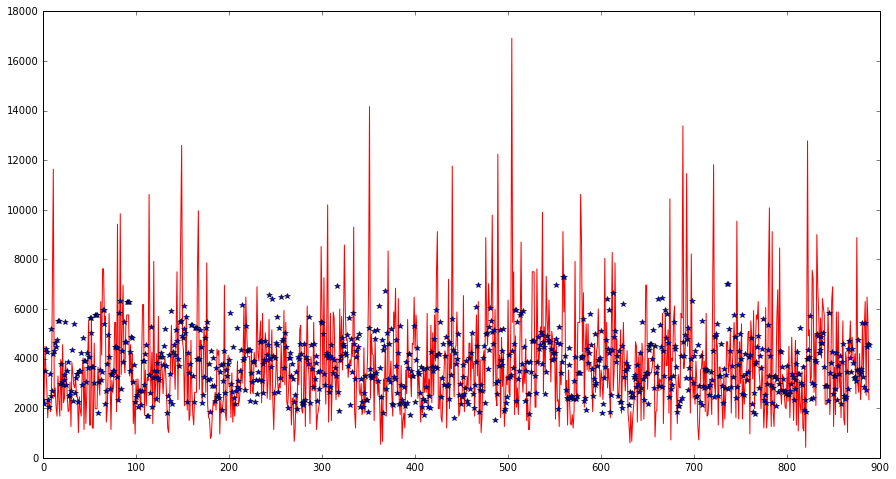

In [361]:
clf = ens.RandomForestRegressor(max_depth = None, min_samples_split= 3, criterion = 'mse',
                                min_samples_leaf = 1, bootstrap = False, max_features = 8)
clf.fit(train[cols],train[target].values)
res =clf.predict(test[cols])
print('quality-L1 ',quality(test[target].values, res))
print('R^2 ',clf.score(test[cols],test[target].values))
print('mape ',mape(list(test[target].values), list(res)))
print('mean diff in minute ',np.mean(np.abs((pd.Series(test[target].values) - pd.Series(res)))/60))
plt.figure(figsize=[15,8])
plt.plot(test[target].values,'-r')
plt.plot(res,'*b')    

In [355]:
loss_mape  = make_scorer(mape, greater_is_better=False)
loss_L1  = make_scorer(quality, greater_is_better=False)
loss_mean_err = make_scorer(lambda x,y: np.mean(np.abs((pd.Series(x) - pd.Series(y))/60)), greater_is_better=False)

In [339]:
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,scoring=loss_mape,
                               n_iter=n_iter_search)

start = time()
random_search.fit(train[cols],train[target].values)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.grid_scores_,n_top = 3, )

RandomizedSearchCV took 178.10 seconds for 1000 candidates parameter settings.
Model with rank: 1
"mean: -55.18421, std: 0.62427, params: {'max_depth': None, 'min_samples_split': 2, 'criterion': 'mse', 'min_samples_leaf': 10, 'bootstrap': True, 'max_features': 10}: -55.184 (std: 0.624)
Parameters: {'max_depth': None, 'min_samples_split': 2, 'criterion': 'mse', 'min_samples_leaf': 10, 'bootstrap': True, 'max_features': 10}

Model with rank: 2
"mean: -55.28417, std: 1.56070, params: {'max_depth': None, 'min_samples_split': 4, 'criterion': 'mse', 'min_samples_leaf': 9, 'bootstrap': True, 'max_features': 10}: -55.284 (std: 1.561)
Parameters: {'max_depth': None, 'min_samples_split': 4, 'criterion': 'mse', 'min_samples_leaf': 9, 'bootstrap': True, 'max_features': 10}

Model with rank: 3
"mean: -55.36481, std: 1.22897, params: {'max_depth': None, 'min_samples_split': 8, 'criterion': 'mse', 'min_samples_leaf': 8, 'bootstrap': False, 'max_features': 8}: -55.365 (std: 1.229)
Parameters: {'max_de

In [368]:
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,scoring=loss_mean_err,
                               n_iter=n_iter_search)

start = time()
random_search.fit(train[cols],train[target].values)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.grid_scores_,n_top = 3, )

RandomizedSearchCV took 162.11 seconds for 1000 candidates parameter settings.
Model with rank: 1
"mean: -21.15568, std: 0.57757, params: {'max_depth': None, 'min_samples_split': 6, 'criterion': 'mse', 'min_samples_leaf': 10, 'bootstrap': False, 'max_features': 6}: -21.156 (std: 0.578)
Parameters: {'max_depth': None, 'min_samples_split': 6, 'criterion': 'mse', 'min_samples_leaf': 10, 'bootstrap': False, 'max_features': 6}

Model with rank: 2
"mean: -21.16626, std: 0.42703, params: {'max_depth': 3, 'min_samples_split': 9, 'criterion': 'mse', 'min_samples_leaf': 10, 'bootstrap': False, 'max_features': 10}: -21.166 (std: 0.427)
Parameters: {'max_depth': 3, 'min_samples_split': 9, 'criterion': 'mse', 'min_samples_leaf': 10, 'bootstrap': False, 'max_features': 10}

Model with rank: 3
"mean: -21.21727, std: 0.55686, params: {'max_depth': None, 'min_samples_split': 3, 'criterion': 'mse', 'min_samples_leaf': 9, 'bootstrap': False, 'max_features': 10}: -21.217 (std: 0.557)
Parameters: {'max_dep

In [341]:
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,scoring=loss_L1,
                               n_iter=n_iter_search)

start = time()
random_search.fit(train[cols],train[target].values)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.grid_scores_,n_top = 3, )

RandomizedSearchCV took 180.96 seconds for 1000 candidates parameter settings.
Model with rank: 1
"mean: -0.37372, std: 0.00663, params: {'max_depth': None, 'min_samples_split': 3, 'criterion': 'mse', 'min_samples_leaf': 10, 'bootstrap': False, 'max_features': 10}: -0.374 (std: 0.007)
Parameters: {'max_depth': None, 'min_samples_split': 3, 'criterion': 'mse', 'min_samples_leaf': 10, 'bootstrap': False, 'max_features': 10}

Model with rank: 2
"mean: -0.37551, std: 0.00922, params: {'max_depth': None, 'min_samples_split': 3, 'criterion': 'mse', 'min_samples_leaf': 9, 'bootstrap': False, 'max_features': 7}: -0.376 (std: 0.009)
Parameters: {'max_depth': None, 'min_samples_split': 3, 'criterion': 'mse', 'min_samples_leaf': 9, 'bootstrap': False, 'max_features': 7}

Model with rank: 3
"mean: -0.37573, std: 0.00564, params: {'max_depth': 3, 'min_samples_split': 5, 'criterion': 'mse', 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': 10}: -0.376 (std: 0.006)
Parameters: {'max_depth': 

  0%|          | 0/30 [00:00<?, ?it/s]

{'mape': 41.61344855815519, 'R^2': 0.1480432089956295, 'mae': 1319.6440931717145, 'mean diff in minute': 5.177821660143668, 'mse': 3781860.2781801531, 'quality-L2': 0.19689419843953163, 'quality-L1': 0.34339022068161684}
{'mape': 41.91934323204966, 'R^2': 0.14876708697668806, 'mae': 1318.2369311601058, 'mean diff in minute': 5.175588304312988, 'mse': 3778646.9633598239, 'quality-L2': 0.1967269043040148, 'quality-L1': 0.3430240570499216}


  7%|▋         | 2/30 [00:00<00:02, 10.71it/s]

{'mape': 41.81622350724195, 'R^2': 0.1525586174454141, 'mae': 1316.1178528586161, 'mean diff in minute': 5.02382442157873, 'mse': 3761816.2524310681, 'quality-L2': 0.19585065053107545, 'quality-L1': 0.342472642642541}


 10%|█         | 3/30 [00:00<00:03,  8.66it/s]

{'mape': 41.702134650178195, 'R^2': 0.15538453053617018, 'mae': 1313.6373326825938, 'mean diff in minute': 4.988154396213893, 'mse': 3749271.9443389634, 'quality-L2': 0.1951975588499726, 'quality-L1': 0.341827175902639}


 13%|█▎        | 4/30 [00:00<00:03,  6.88it/s]

{'mape': 41.70612634794009, 'R^2': 0.15520924464517505, 'mae': 1314.1818095617468, 'mean diff in minute': 4.964022238646267, 'mse': 3750050.0433640308, 'quality-L2': 0.19523806885631298, 'quality-L1': 0.34196885655476067}


 17%|█▋        | 5/30 [00:00<00:04,  5.57it/s]

{'mape': 41.7044543594281, 'R^2': 0.16065368245950462, 'mae': 1311.3102975089237, 'mean diff in minute': 4.859110944679281, 'mse': 3725882.0300041493, 'quality-L2': 0.19397981464585862, 'quality-L1': 0.3412216481501528}


 20%|██        | 6/30 [00:01<00:05,  4.59it/s]

{'mape': 41.737918173285664, 'R^2': 0.15993551493580727, 'mae': 1311.968778614829, 'mean diff in minute': 4.819434994699543, 'mse': 3729069.9959428306, 'quality-L2': 0.19414578904786658, 'quality-L1': 0.3413929943285968}


 23%|██▎       | 7/30 [00:01<00:05,  3.86it/s]

{'mape': 41.73985197838916, 'R^2': 0.15984323861206107, 'mae': 1311.9203770488332, 'mean diff in minute': 4.800246283949681, 'mse': 3729479.6131523852, 'quality-L2': 0.19416711486273264, 'quality-L1': 0.34138039955056976}


 27%|██▋       | 8/30 [00:01<00:06,  3.31it/s]

{'mape': 41.74467854101259, 'R^2': 0.16239580644637097, 'mae': 1311.2983855658101, 'mean diff in minute': 4.773180468848401, 'mse': 3718148.6923805038, 'quality-L2': 0.19357719551118183, 'quality-L1': 0.34121854849260436}


 30%|███       | 9/30 [00:02<00:07,  2.89it/s]

{'mape': 41.808050157918245, 'R^2': 0.16239356591198517, 'mae': 1311.6488419255552, 'mean diff in minute': 4.707467026568322, 'mse': 3718158.6381759769, 'quality-L2': 0.19357771331704507, 'quality-L1': 0.34130974223744426}


 33%|███▎      | 10/30 [00:02<00:07,  2.55it/s]

{'mape': 41.83185418368593, 'R^2': 0.16136234560831941, 'mae': 1311.8419513993977, 'mean diff in minute': 4.78712833095221, 'mse': 3722736.2542542391, 'quality-L2': 0.19381603678279913, 'quality-L1': 0.34135999207767176}


 37%|███▋      | 11/30 [00:03<00:08,  2.28it/s]

{'mape': 41.829709342697825, 'R^2': 0.16172232613732118, 'mae': 1311.6378256413343, 'mean diff in minute': 4.778064420753298, 'mse': 3721138.2905101567, 'quality-L2': 0.1937328423315545, 'quality-L1': 0.3413068756431178}


 40%|████      | 12/30 [00:03<00:08,  2.07it/s]

{'mape': 41.842278316612514, 'R^2': 0.16222560373006223, 'mae': 1311.3948190913952, 'mean diff in minute': 4.738812231342913, 'mse': 3718904.2270494476, 'quality-L2': 0.19361653075418214, 'quality-L1': 0.34124364187179895}


 43%|████▎     | 13/30 [00:04<00:09,  1.89it/s]

{'mape': 41.840684548346005, 'R^2': 0.16200776056172161, 'mae': 1311.6074565697475, 'mean diff in minute': 4.7478608814792596, 'mse': 3719871.2390316506, 'quality-L2': 0.19366687609618605, 'quality-L1': 0.34129897317740965}


 47%|████▋     | 14/30 [00:05<00:09,  1.74it/s]

{'mape': 41.86093741572932, 'R^2': 0.161719204502206, 'mae': 1311.9431579837581, 'mean diff in minute': 4.722443312082082, 'mse': 3721152.1475366745, 'quality-L2': 0.19373356376701995, 'quality-L1': 0.3413863274748574}


 50%|█████     | 15/30 [00:06<00:09,  1.60it/s]

{'mape': 41.84748768015494, 'R^2': 0.16175836612740724, 'mae': 1311.8167984334664, 'mean diff in minute': 4.7196773956044975, 'mse': 3720978.3079753947, 'quality-L2': 0.1937245131944027, 'quality-L1': 0.34135344691707353}


 53%|█████▎    | 16/30 [00:06<00:09,  1.49it/s]

{'mape': 41.81905367675289, 'R^2': 0.16147380167695269, 'mae': 1311.7639651861746, 'mean diff in minute': 4.730140208422052, 'mse': 3722241.4976149625, 'quality-L2': 0.19379027837166082, 'quality-L1': 0.3413396989523453}


 57%|█████▋    | 17/30 [00:07<00:09,  1.39it/s]

{'mape': 41.81497788720863, 'R^2': 0.16108011577777726, 'mae': 1311.9067949357566, 'mean diff in minute': 4.725341903635225, 'mse': 3723989.0804500217, 'quality-L2': 0.19388126241025713, 'quality-L1': 0.34137686529096817}


 60%|██████    | 18/30 [00:08<00:09,  1.31it/s]

{'mape': 41.79065404374704, 'R^2': 0.16069932744384763, 'mae': 1311.9990198256162, 'mean diff in minute': 4.7429196214866955, 'mse': 3725679.4106283691, 'quality-L2': 0.19396926571579548, 'quality-L1': 0.34140086352310145}


 63%|██████▎   | 19/30 [00:09<00:08,  1.23it/s]

{'mape': 41.80328487968875, 'R^2': 0.16067806746543756, 'mae': 1312.1239299161998, 'mean diff in minute': 4.725331067671501, 'mse': 3725773.7842735038, 'quality-L2': 0.19397417907108763, 'quality-L1': 0.34143336691078957}


 67%|██████▋   | 20/30 [00:10<00:08,  1.17it/s]

{'mape': 41.83530773819918, 'R^2': 0.16102641514551419, 'mae': 1312.2158312234308, 'mean diff in minute': 4.678624029648696, 'mse': 3724227.4590746341, 'quality-L2': 0.1938936730665921, 'quality-L1': 0.34145728094210615}


 70%|███████   | 21/30 [00:11<00:08,  1.10it/s]

{'mape': 41.82796950077674, 'R^2': 0.16067040896319673, 'mae': 1312.3549958470769, 'mean diff in minute': 4.6949785718930155, 'mse': 3725807.7805814394, 'quality-L2': 0.19397594901373724, 'quality-L1': 0.34149349356266984}


 73%|███████▎  | 22/30 [00:12<00:07,  1.05it/s]

{'mape': 41.799332907227935, 'R^2': 0.16047031198085404, 'mae': 1311.9254964068305, 'mean diff in minute': 4.723556554215424, 'mse': 3726696.0167423524, 'quality-L2': 0.1940221930666803, 'quality-L1': 0.3413817316805596}


 77%|███████▋  | 23/30 [00:13<00:06,  1.00it/s]

{'mape': 41.80337823542234, 'R^2': 0.16057078598925612, 'mae': 1312.0276681020737, 'mean diff in minute': 4.710462430220845, 'mse': 3726250.00977888, 'quality-L2': 0.19399897269968833, 'quality-L1': 0.3414083182133668}


 80%|████████  | 24/30 [00:14<00:06,  1.05s/it]

{'mape': 41.83862978388312, 'R^2': 0.16072124042643943, 'mae': 1312.3221653132875, 'mean diff in minute': 4.661045450115454, 'mse': 3725582.1382792131, 'quality-L2': 0.19396420144588336, 'quality-L1': 0.3414849505893777}


 83%|████████▎ | 25/30 [00:15<00:05,  1.09s/it]

{'mape': 41.83962685752911, 'R^2': 0.16080883876109597, 'mae': 1312.4470075964971, 'mean diff in minute': 4.635516001090087, 'mse': 3725193.2867954639, 'quality-L2': 0.1939439567526445, 'quality-L1': 0.34151743633262027}


 87%|████████▋ | 26/30 [00:17<00:04,  1.14s/it]

{'mape': 41.83747496779593, 'R^2': 0.16074661555975067, 'mae': 1312.4718128827981, 'mean diff in minute': 4.636523044857595, 'mse': 3725469.4973451467, 'quality-L2': 0.1939583370445593, 'quality-L1': 0.34152389102201763}


 90%|█████████ | 27/30 [00:18<00:03,  1.19s/it]

{'mape': 41.84805533880659, 'R^2': 0.16088902037297848, 'mae': 1312.5280693235929, 'mean diff in minute': 4.618974276707939, 'mse': 3724837.3583537629, 'quality-L2': 0.1939254261248381, 'quality-L1': 0.34153852975053517}


 93%|█████████▎| 28/30 [00:19<00:02,  1.24s/it]

{'mape': 41.8428260923022, 'R^2': 0.16074349560800361, 'mae': 1312.6066593187777, 'mean diff in minute': 4.624591010177743, 'mse': 3725483.3468991457, 'quality-L2': 0.19395905809098402, 'quality-L1': 0.34155897998854173}


 97%|█████████▋| 29/30 [00:21<00:01,  1.28s/it]

{'mape': 41.85965167740351, 'R^2': 0.1609191363866318, 'mae': 1312.7391634331086, 'mean diff in minute': 4.596867722571056, 'mse': 3724703.6725178435, 'quality-L2': 0.19391846606720267, 'quality-L1': 0.34159345944955477}


100%|██████████| 30/30 [00:22<00:00,  1.33s/it]


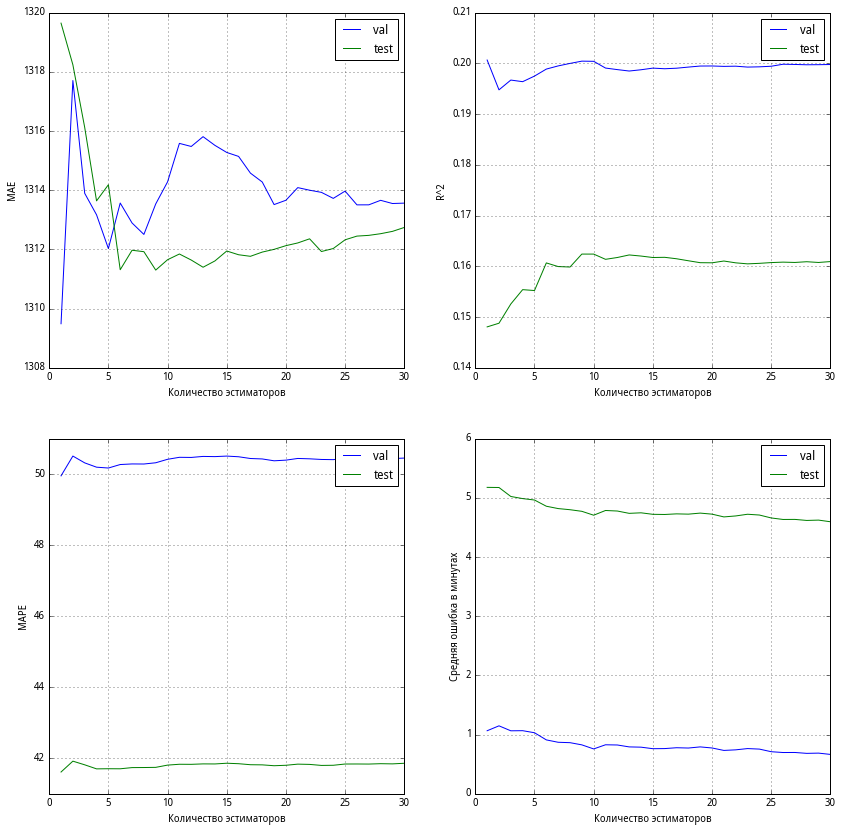

In [340]:
plt.figure(figsize=[10,10])
t_1 = []
t_2 = []
t_3 = []
t_4 = []
t_1_ = []
t_2_ = []
t_3_ = []
t_4_ = []
n = 31
for est in tqdm(range(1,n)):
    model = ens.RandomForestRegressor(n_estimators=est,max_depth=2,random_state=42)
    model.fit(train[cols],train[target].values)
    res = model.predict(val[cols])
    res_test = model.predict(test[cols])
    t_1.append(mean_absolute_error(val[target].values, res))
    t_2.append(model.score(val[cols],val[target].values))
    t_3.append((mape(list(val[target].values), list(res))))
    t_4.append(np.mean((pd.Series(val[target].values) - pd.Series(res))/60))
    
    t_1_.append(mean_absolute_error(test[target].values, res_test))
    t_2_.append(model.score(test[cols],test[target].values))
    t_3_.append((mape(list(test[target].values), list(res_test))))
    t_4_.append(np.mean((pd.Series(test[target].values) - pd.Series(res_test))/60))
    print(results(test[target].values, res_test))

plt.figure(figsize=[14,14])
plt.subplot(221)
plt.grid(True)
plt.plot(range(1,n),t_1)
plt.plot(range(1,n),t_1_)
plt.legend(['val','test'])
plt.xlabel('Количество эстиматоров')
plt.ylabel('MAE')
plt.subplot(222)
plt.grid(True)
plt.plot(range(1,n),t_2)
plt.plot(range(1,n),t_2_)
plt.legend(['val','test'])
plt.ylabel('R^2')
plt.xlabel('Количество эстиматоров')
plt.subplot(223)
plt.grid(True)
plt.plot(range(1,n),t_3)
plt.plot(range(1,n),t_3_)
plt.legend(['val','test'])
plt.ylabel('MAPE')
plt.xlabel('Количество эстиматоров')
plt.subplot(224)
plt.plot(range(1,n),t_4)
plt.plot(range(1,n),t_4_)
plt.legend(['val','test'])
plt.ylabel('Средняя ошибка в минутах')
plt.xlabel('Количество эстиматоров')
plt.grid(True)

100%|██████████| 30/30 [00:52<00:00,  3.10s/it]


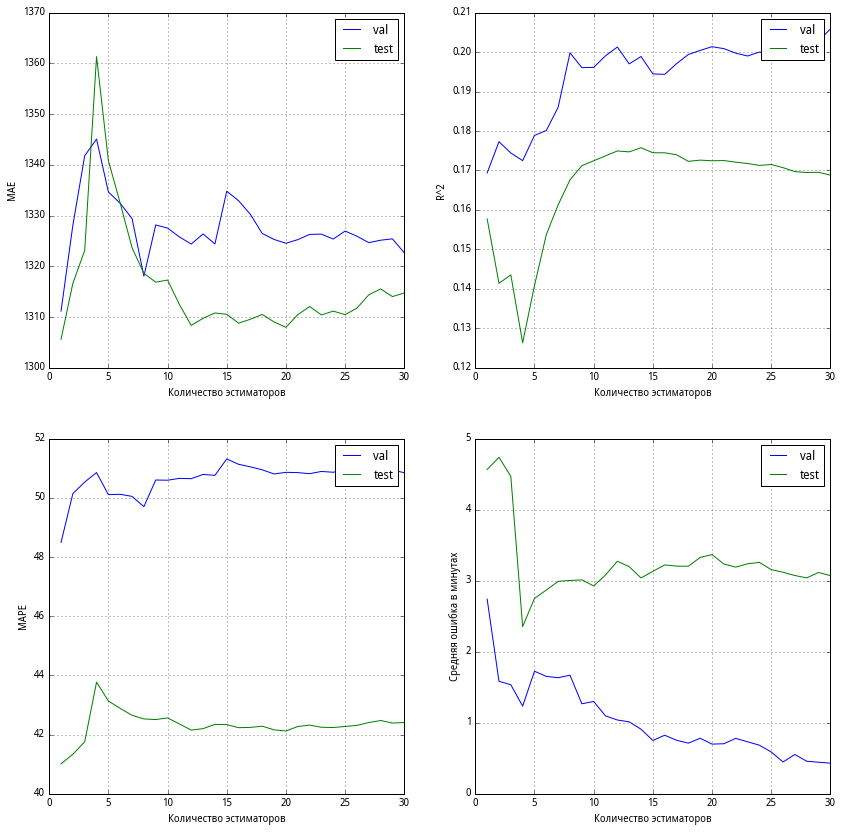

In [337]:
plt.figure(figsize=[10,10])
t_1 = []
t_2 = []
t_3 = []
t_4 = []
t_1_ = []
t_2_ = []
t_3_ = []
t_4_ = []
n = 31
for est in tqdm(range(1,n)):
    model = ens.RandomForestRegressor(n_estimators=est,max_depth=5,random_state=42)
    model.fit(train[cols],train[target].values)
    res = model.predict(val[cols])
    res_test = model.predict(test[cols])
    t_1.append(mean_absolute_error(val[target].values, res))
    t_2.append(model.score(val[cols],val[target].values))
    t_3.append((mape(list(val[target].values), list(res))))
    t_4.append(np.mean((pd.Series(val[target].values) - pd.Series(res))/60))
    
    t_1_.append(mean_absolute_error(test[target].values, res_test))
    t_2_.append(model.score(test[cols],test[target].values))
    t_3_.append((mape(list(test[target].values), list(res_test))))
    t_4_.append(np.mean((pd.Series(test[target].values) - pd.Series(res_test))/60))
    #print(results(test[target].values, res_test))

plt.figure(figsize=[14,14])
plt.subplot(221)
plt.grid(True)
plt.plot(range(1,n),t_1)
plt.plot(range(1,n),t_1_)
plt.legend(['val','test'])
plt.xlabel('Количество эстиматоров')
plt.ylabel('MAE')
plt.subplot(222)
plt.grid(True)
plt.plot(range(1,n),t_2)
plt.plot(range(1,n),t_2_)
plt.legend(['val','test'])
plt.ylabel('R^2')
plt.xlabel('Количество эстиматоров')
plt.subplot(223)
plt.grid(True)
plt.plot(range(1,n),t_3)
plt.plot(range(1,n),t_3_)
plt.legend(['val','test'])
plt.ylabel('MAPE')
plt.xlabel('Количество эстиматоров')
plt.subplot(224)
plt.plot(range(1,n),t_4)
plt.plot(range(1,n),t_4_)
plt.legend(['val','test'])
plt.ylabel('Средняя ошибка в минутах')
plt.xlabel('Количество эстиматоров')
plt.grid(True)

100%|██████████| 30/30 [01:37<00:00,  5.79s/it]


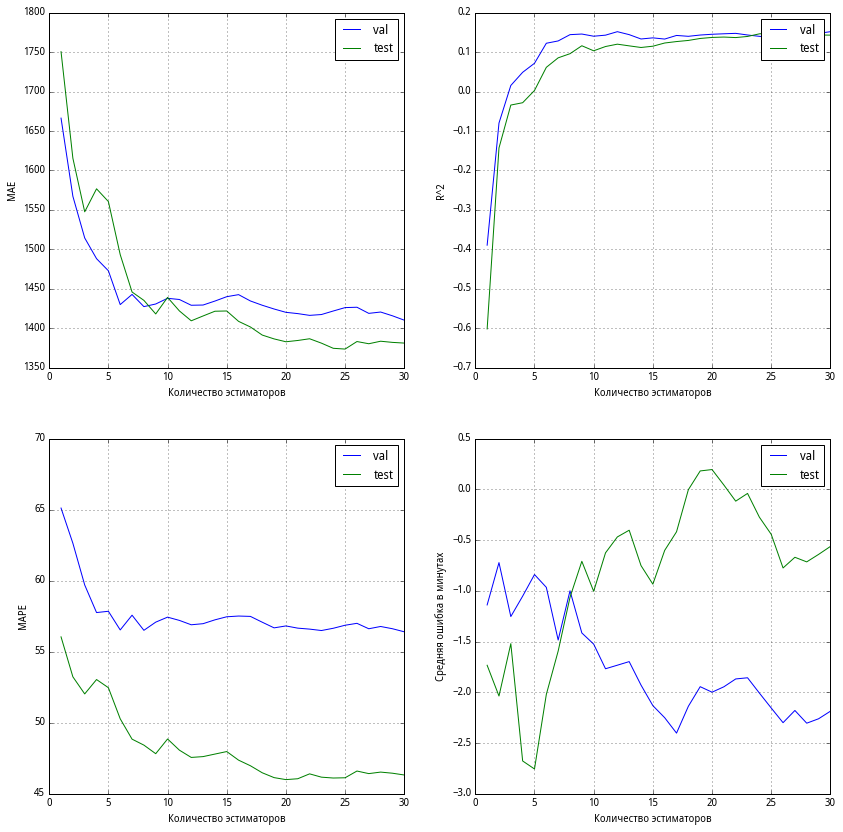

In [338]:
plt.figure(figsize=[10,10])
t_1 = []
t_2 = []
t_3 = []
t_4 = []
t_1_ = []
t_2_ = []
t_3_ = []
t_4_ = []
n = 31
for est in tqdm(range(1,n)):
    model = ens.RandomForestRegressor(n_estimators=est,max_depth=10,random_state=42)
    model.fit(train[cols],train[target].values)
    res = model.predict(val[cols])
    res_test = model.predict(test[cols])
    t_1.append(mean_absolute_error(val[target].values, res))
    t_2.append(model.score(val[cols],val[target].values))
    t_3.append((mape(list(val[target].values), list(res))))
    t_4.append(np.mean((pd.Series(val[target].values) - pd.Series(res))/60))
    
    t_1_.append(mean_absolute_error(test[target].values, res_test))
    t_2_.append(model.score(test[cols],test[target].values))
    t_3_.append((mape(list(test[target].values), list(res_test))))
    t_4_.append(np.mean((pd.Series(test[target].values) - pd.Series(res_test))/60))
    #print(results(test[target].values, res_test))

plt.figure(figsize=[14,14])
plt.subplot(221)
plt.grid(True)
plt.plot(range(1,n),t_1)
plt.plot(range(1,n),t_1_)
plt.legend(['val','test'])
plt.xlabel('Количество эстиматоров')
plt.ylabel('MAE')
plt.subplot(222)
plt.grid(True)
plt.plot(range(1,n),t_2)
plt.plot(range(1,n),t_2_)
plt.legend(['val','test'])
plt.ylabel('R^2')
plt.xlabel('Количество эстиматоров')
plt.subplot(223)
plt.grid(True)
plt.plot(range(1,n),t_3)
plt.plot(range(1,n),t_3_)
plt.legend(['val','test'])
plt.ylabel('MAPE')
plt.xlabel('Количество эстиматоров')
plt.subplot(224)
plt.plot(range(1,n),t_4)
plt.plot(range(1,n),t_4_)
plt.legend(['val','test'])
plt.ylabel('Средняя ошибка в минутах')
plt.xlabel('Количество эстиматоров')
plt.grid(True)

# Neural Network

import theano
import theano.tensor as T

rng = np.random
N = train.shape[0]
#Количество столбцов
feats = len(cols)
#Количество тренировочных шагов
training_steps = 10000

# Декларируем символьные переменные Theano 
x = T.matrix("x")
y = T.vector("y")
w = theano.shared(rng.randn(feats), name="w")
b = theano.shared(0., name="b")

X = train[cols]
Y = train[target].values
min_ = min(Y)
max_ = max(Y)
Y = (Y-min_)/(max_-min_)

# Создаем «выражение» Theano
p_1 = 1 / (1 + T.exp(-T.dot(x, w) - b))           # Вероятность того, что результат равен  1
prediction = p_1                                   # Порог для прогнозирования
xent = -y * T.log(p_1) - (1-y) * T.log(1-p_1) # Функция ошибки для перекрестной энтропии
cost = xent.mean() + 0.01 * (w ** 2).sum()  # Стоимость минимизации
gw,gb = T.grad(cost, [w, b])                          # Рассчитываем градиент стоимости
                                          
# Компилируем «выражение» Theano
train_ = theano.function(
          inputs=[x,y],
          outputs=[prediction, xent],
          updates=((w, w - 0.1 * gw), (b, b - 0.1 * gb)))
predict = theano.function(inputs=[x], outputs=prediction)

# Тренировка модели
for i in tqdm(range(training_steps)):
    pred, err = train_(X, Y)

#Прогнозирование
P = predict(test[cols])
#Сохраняем в файл

In [ ]:
from pybrain.tools.shortcuts import buildNetwork

In [ ]:
net = buildNetwork(len(cols), 10, 1)

In [ ]:
net.activate(np.random.random(len(cols)))

In [ ]:
from pybrain.datasets import SupervisedDataSet

In [ ]:
def normalization(df, cols):
    df_res = pd.DataFrame()
    df_res['Arrive'] = df.Arrive
    for i in cols:
        temp = (df[i] - min(df[i]))/(max(df[i]) - min(df[i]))
        df_res[i] = temp
    temp = (df['time_of_expected'] - min(df['time_of_expected']))/(max(df['time_of_expected']) - min(df['time_of_expected']))
    df_res['time_of_expected'] = temp
    df_res = df_res.set_index(df.index)
    return df_res

In [ ]:
df_temp = df.sort_values('time_of_expected')
df_temp = df_temp[4:df.shape[0]-3]
df_norm = normalization(df_temp,cols)
date_threshold = datetime.strptime('15.03.2015','%d.%m.%Y')
train_norm = df_norm[df_norm.Arrive < date_threshold]
test_norm = df_norm[df_norm.Arrive >= date_threshold]
train_norm = train_norm.sort_values('Arrive')
test_norm = test_norm.sort_values('Arrive')

In [ ]:
ds = SupervisedDataSet(len(cols), 1)
for i in tqdm(train_norm.index):
    X = list(train_norm.loc[i,cols].values)
    y = (train_norm.loc[i,target])
    ds.addSample(X,y)

In [ ]:
len(ds['input'])

In [ ]:
import pybrain.supervised.trainers as trn

In [ ]:
trainer = trn.BackpropTrainer(net, ds,learningrate=0.05)

In [ ]:
err = trainer.trainUntilConvergence(maxEpochs=1000, verbose = 100)

In [ ]:
plt.plot(err[0])

In [ ]:
res = []
for i in tqdm(train_norm.index):
    X = list(train_norm.loc[i,cols].values)
    res.append(net.activate(X)[0])
print('quality-pianyh ',quality(train_norm[target].values, res))
print('mape ',mape(list(train_norm[target].values), list(res)))
plt.plot(train_norm[target].values,'r')
plt.plot(res,'b')

In [ ]:
res = []
for i in tqdm(test.index):
    X = list(test.loc[i,cols].values)
    res.append(net.activate(X)[0])
print('quality-pianyh ',quality(test[target].values, res))
print('mape ',mape(list(test[target].values), list(res)))
plt.plot(test[target].values,'r')
plt.plot(res,'b')

# END of Networks

# Смотрю штуки всякие

- без аутлаеров (более 10 тысяч секунд на процедуру) получает вполне себе такая симпатичная диаграммка

In [ ]:
temp = df['time_of_procedure']
temp = temp.sort_values()
temp = list(temp)
a = plt.hist(temp[:-3],bins = 30)

In [ ]:
a = plt.hist(df.len_of_queque, bins = 5)

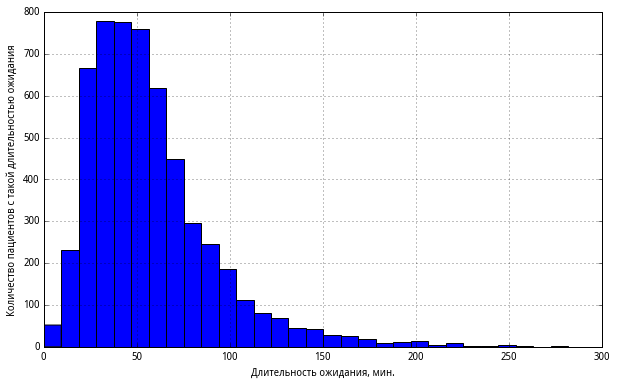

In [76]:
temp = df['time_of_expected']
plt.figure(figsize=[10,6])
temp = temp.sort_values()
temp = list(temp)
a = plt.hist(pd.Series(temp[3:-3])/60,bins = 30)
plt.grid(True)
plt.xlabel('Длительность ожидания, мин.')
plt.ylabel('Количество пациентов с такой длительностью ожидания')

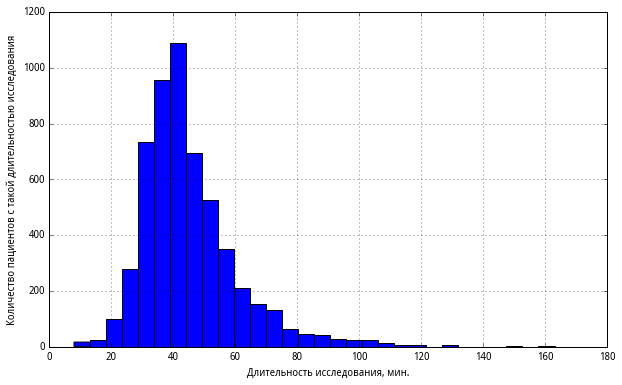

In [71]:
plt.figure(figsize=[10,6])
temp = df['time_of_procedure']
temp = temp.sort_values()
temp = list(temp)
a = plt.hist(pd.Series(temp[3:-3])/60,bins = 30)
plt.grid(True)
plt.xlabel('Длительность исследования, мин.')
plt.ylabel('Количество пациентов с такой длительностью исследования')

# Estimate result

1. Берем первый элемент df и предсказываем для него 

# Ideas

1. Предсказывать для каждого прихода время ожидания + время проведения исследования и использовать это как фичи
2. Брать среднее от линейной регрессии и какого нибудь бустинга